# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('../..')
from src import BMCA, util
import emll

# Perturbing enzymes

In [3]:
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/enzymeCompilation.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

5.935978122618177e-12

In [ ]:
BIOMD64_05 = BMCA.BMCA(Teusink_ant, 'data/interim/generated_data/BIOMD0000000064_e_extANDenzyme0.5perts.csv')
BIOMD64_08 = BMCA.BMCA(Teusink_ant, 'data/interim/generated_data/BIOMD0000000064_e_extANDenzyme0.8perts.csv')
BIOMD64_09 = BMCA.BMCA(Teusink_ant, 'data/interim/generated_data/BIOMD0000000064_e_extANDenzyme0.9perts.csv')
BIOMD64_11 = BMCA.BMCA(Teusink_ant, 'data/interim/generated_data/BIOMD0000000064_e_extANDenzyme1.1perts.csv')
BIOMD64_12 = BMCA.BMCA(Teusink_ant, 'data/interim/generated_data/BIOMD0000000064_e_extANDenzyme1.2perts.csv')
BIOMD64_15 = BMCA.BMCA(Teusink_ant, 'data/interim/generated_data/BIOMD0000000064_e_extANDenzyme1.5perts.csv')

In [7]:
def run_BayesInf(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)


    N_ITERATIONS = 50000
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, 50000])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)
        

In [6]:
trace05 = run_BayesInf(BIOMD64_05)

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 13,644


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,738


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,656.3


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,659


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,780.8


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 10,825


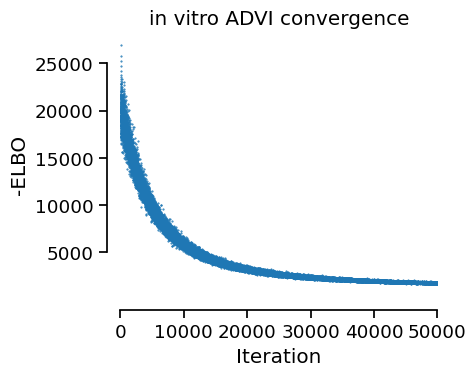

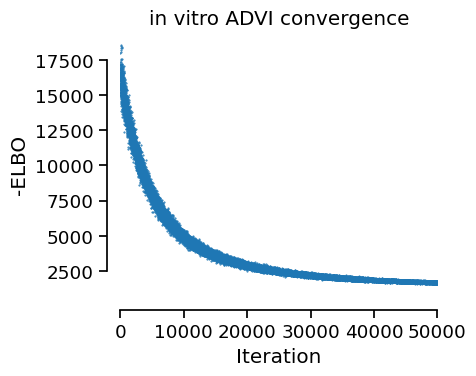

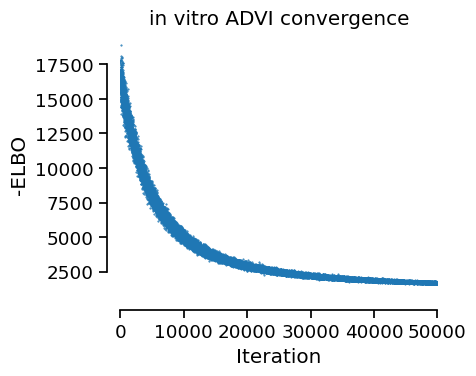

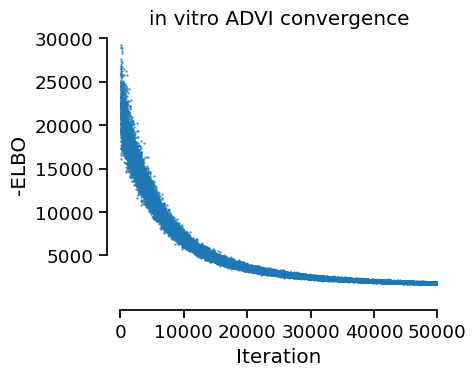

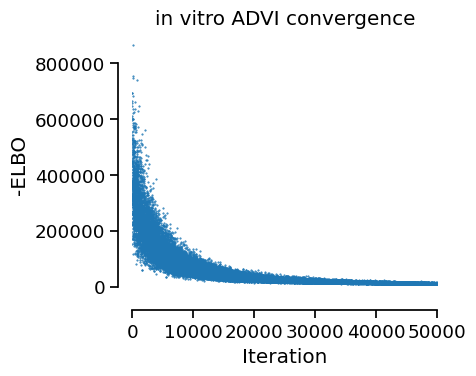

In [10]:
trace08 = run_BayesInf(BIOMD64_08)
trace09 = run_BayesInf(BIOMD64_09)
trace11 = run_BayesInf(BIOMD64_11)
trace12 = run_BayesInf(BIOMD64_12)
trace15 = run_BayesInf(BIOMD64_15)

In [11]:
Ex_05 = (trace05['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_08 = (trace08['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_09 = (trace09['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_11 = (trace11['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_12 = (trace12['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_15 = (trace15['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)

In [16]:
all_traces = [Ex_05, Ex_08, Ex_09, Ex_11, Ex_12, Ex_15]

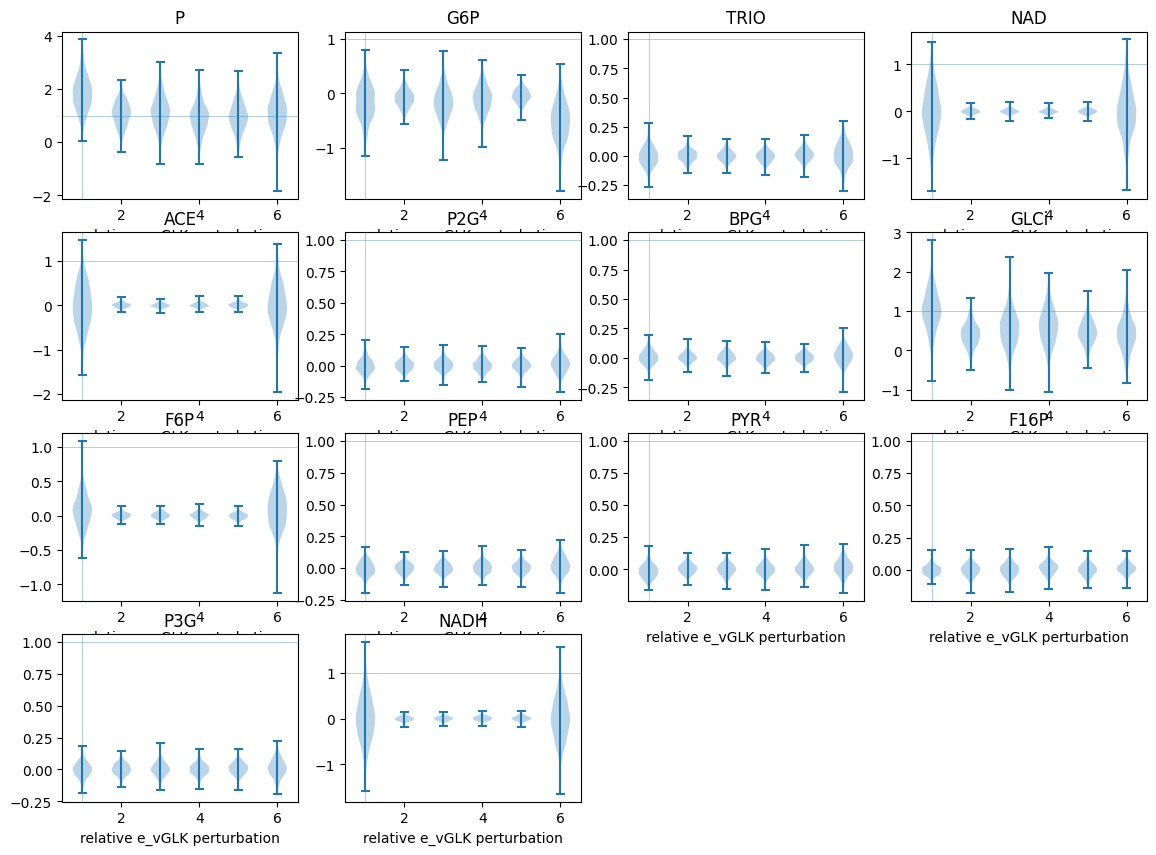

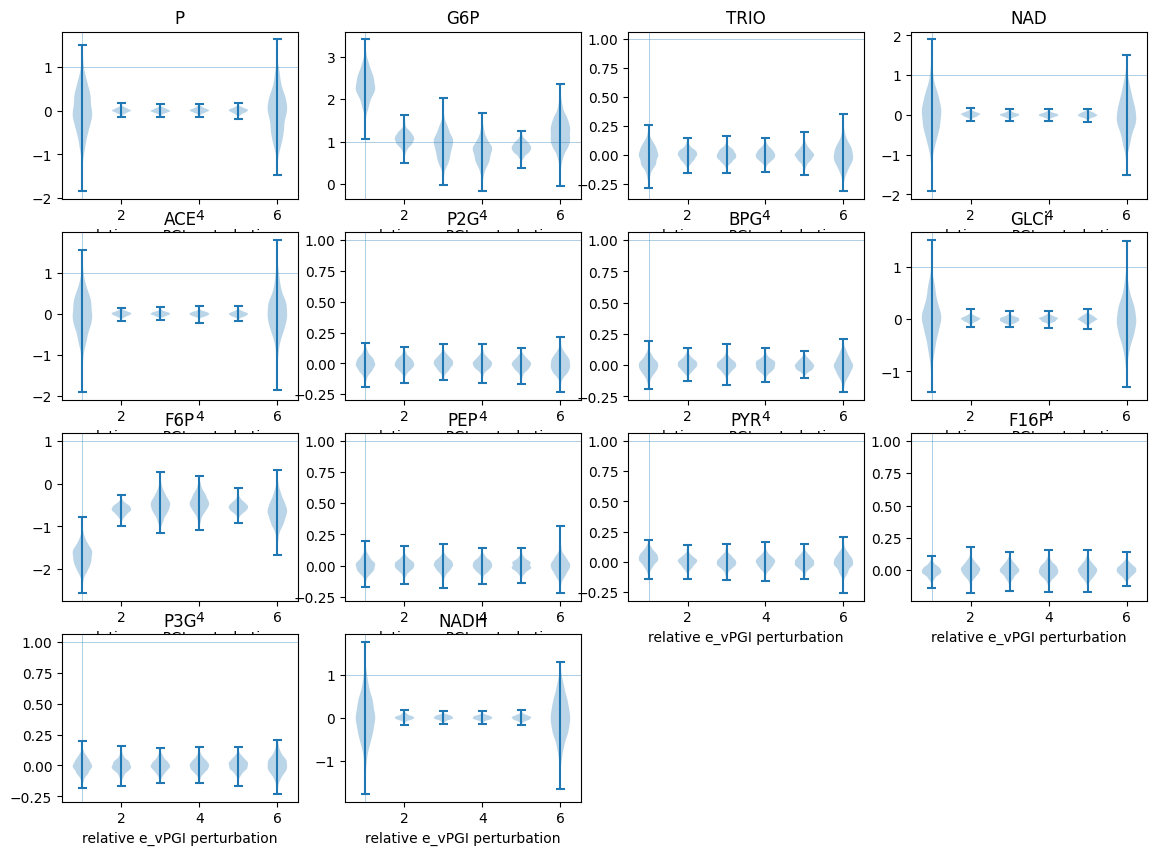

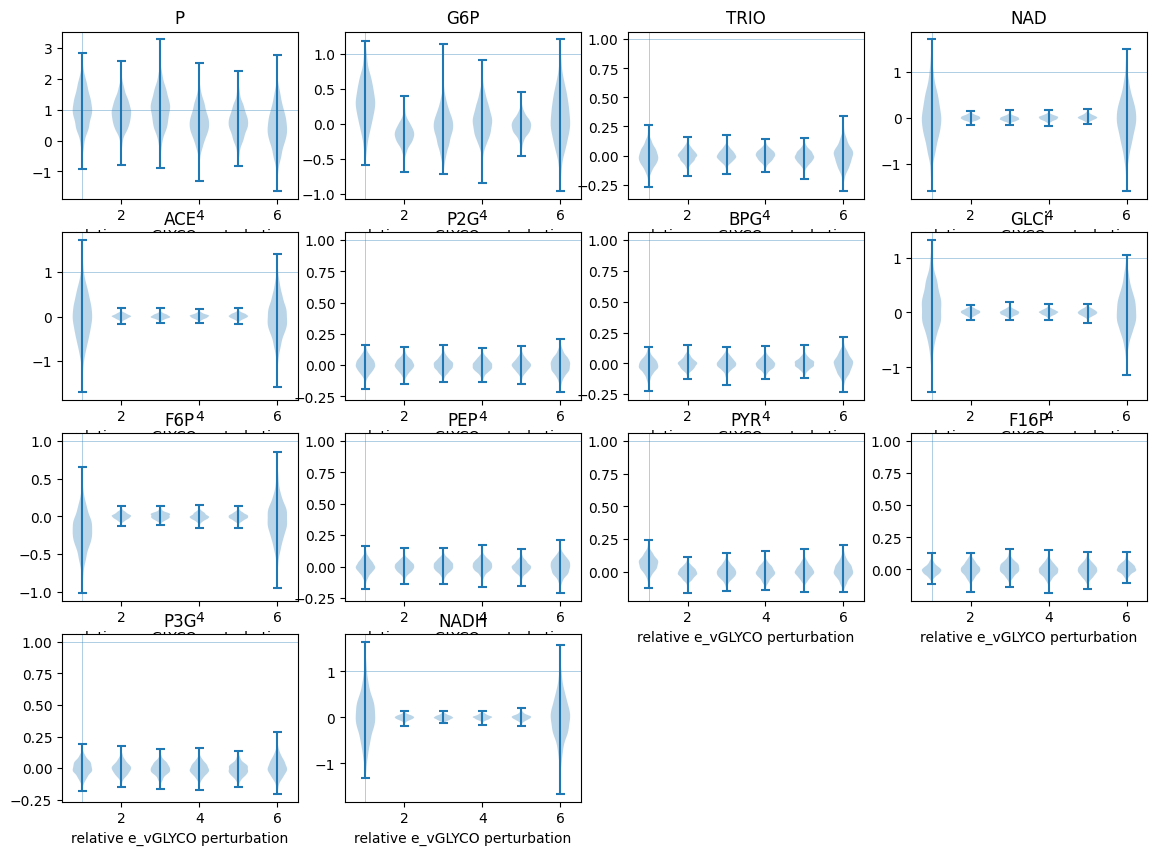

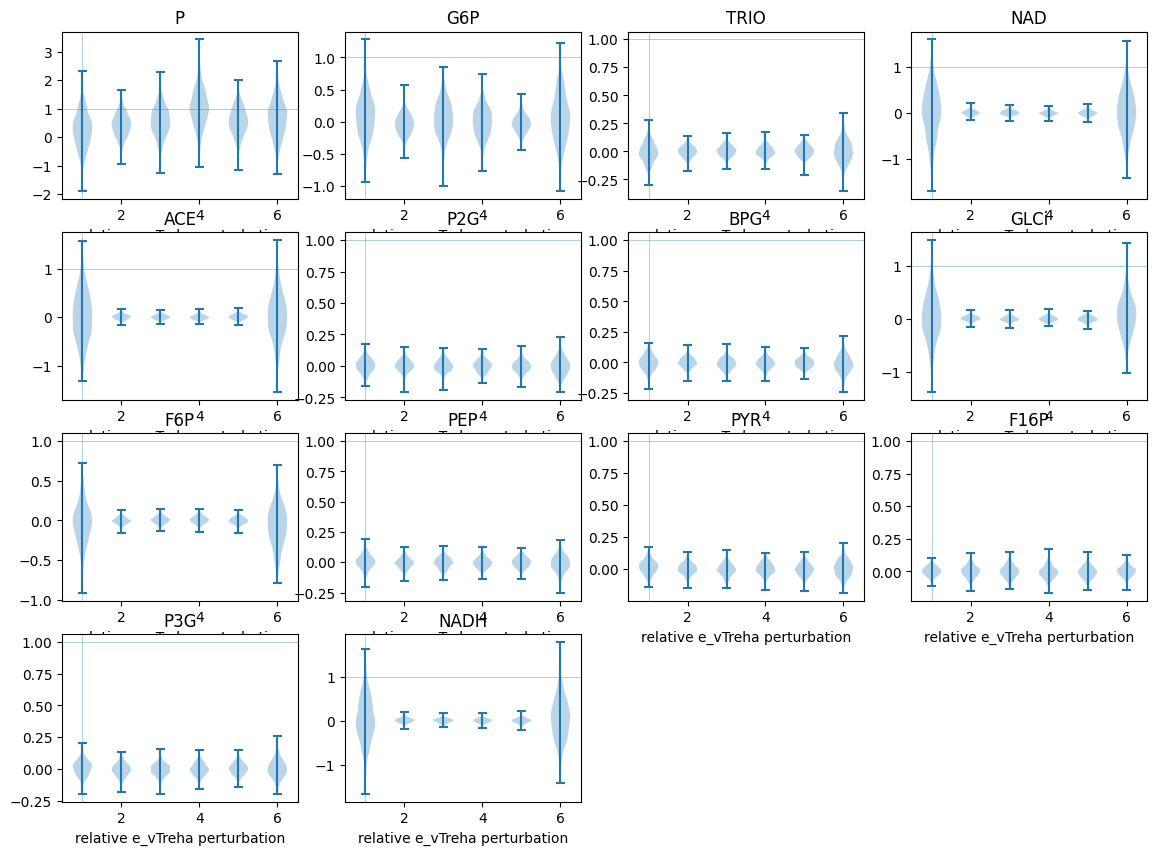

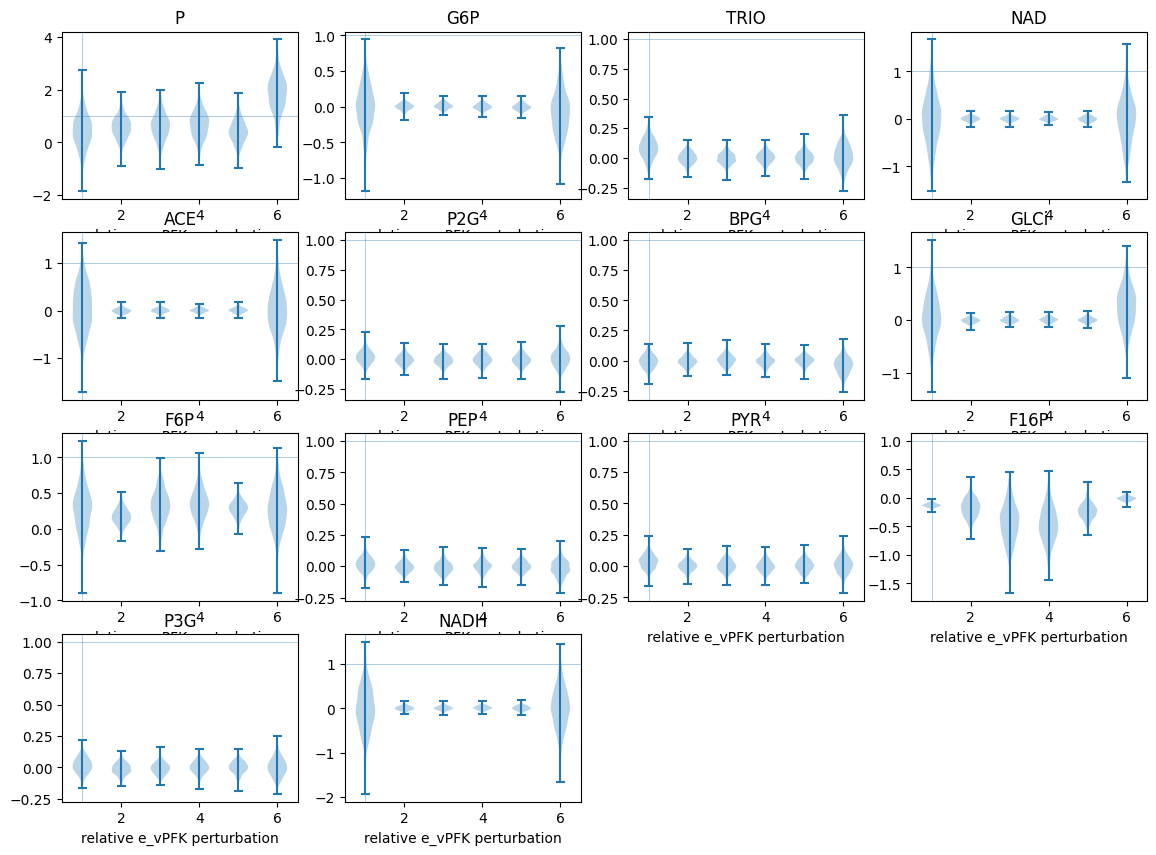

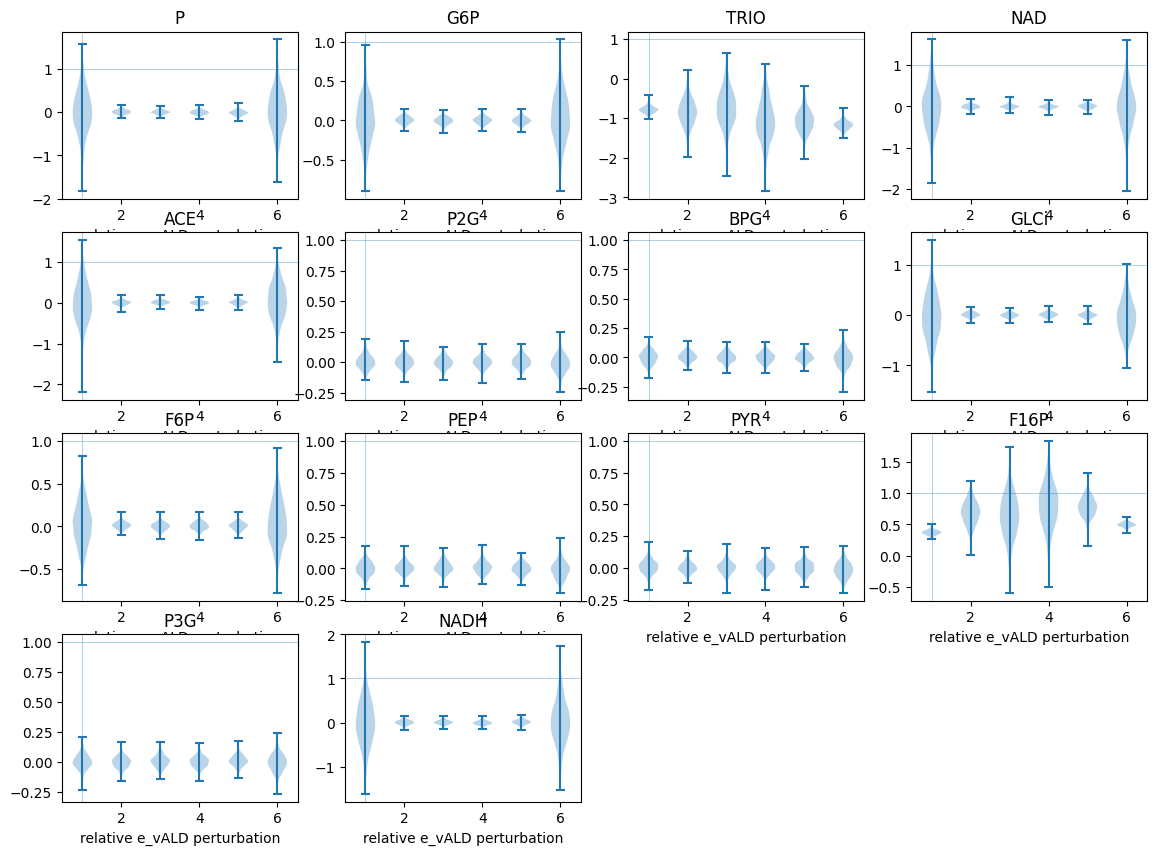

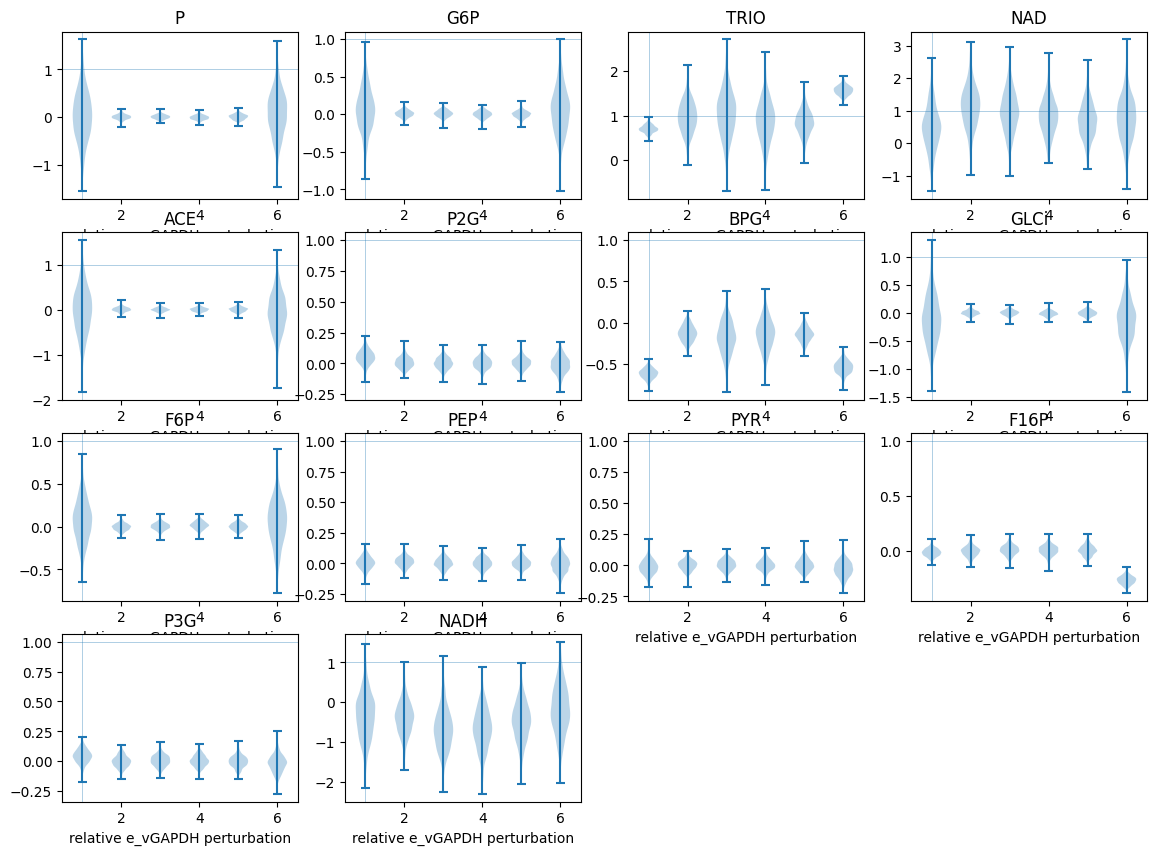

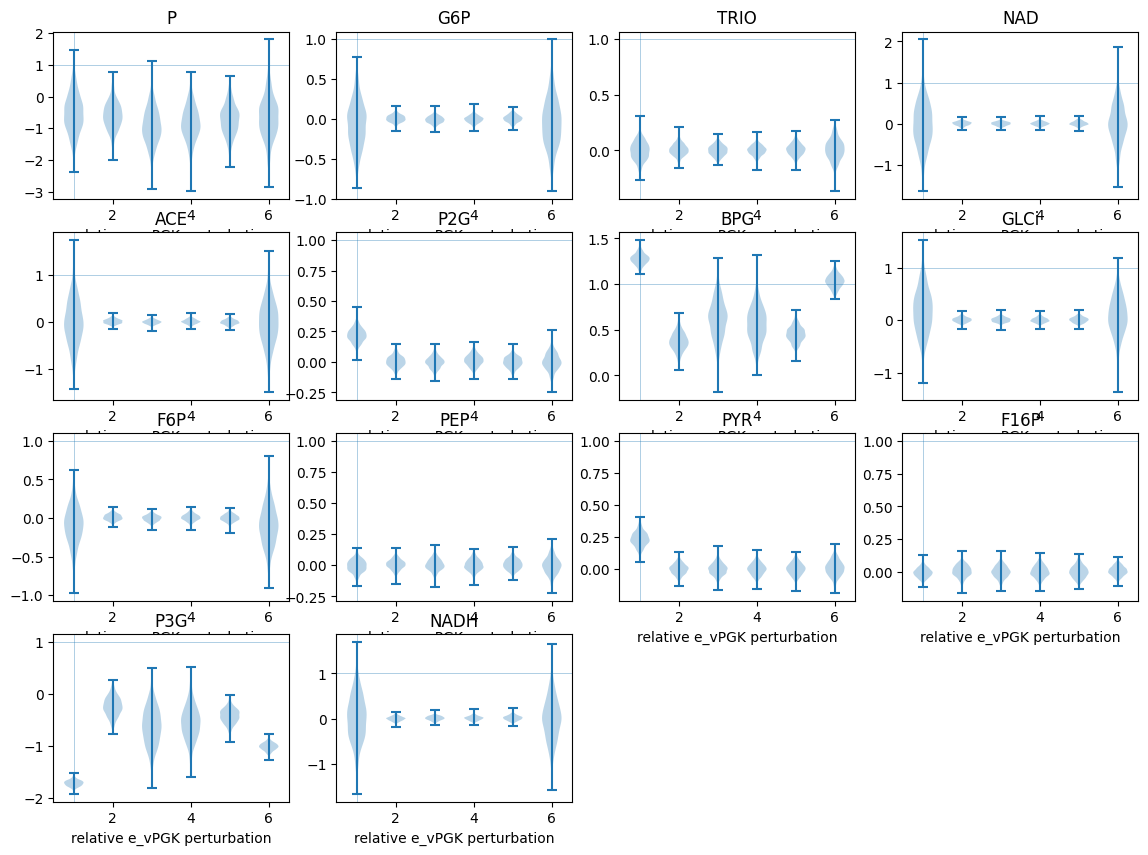

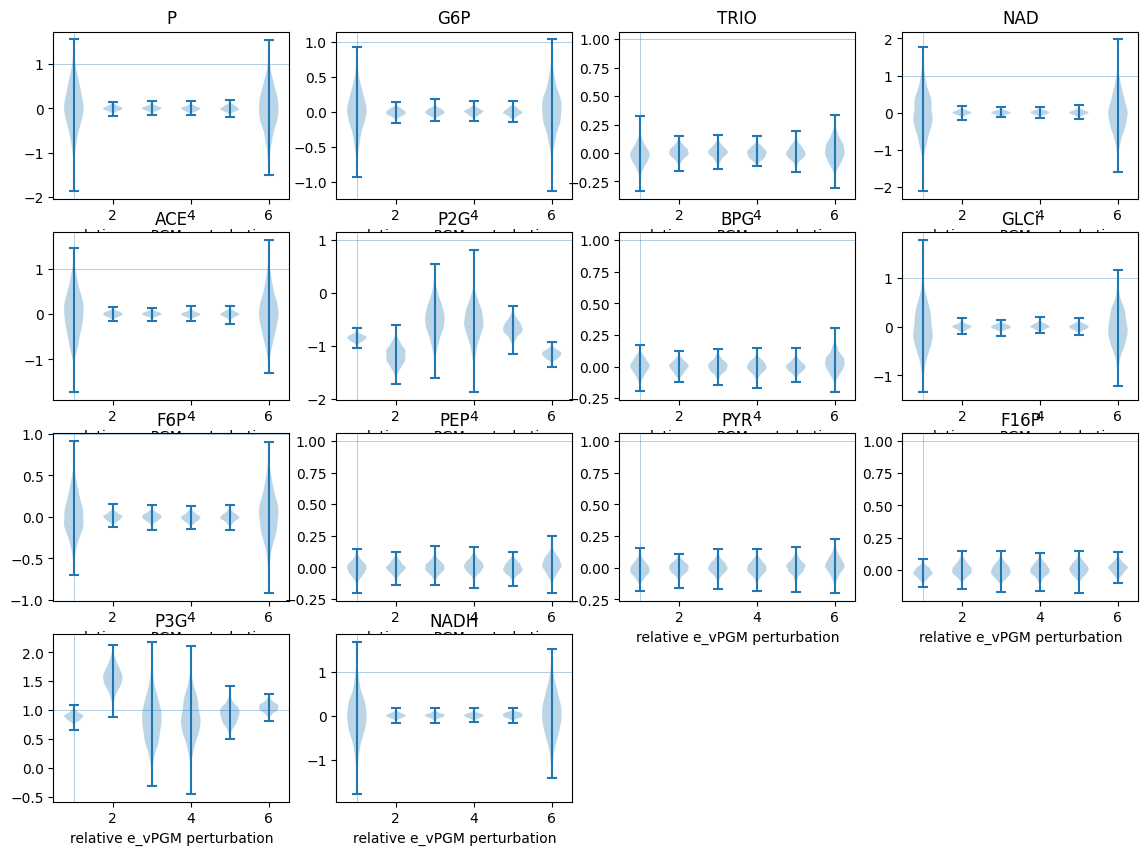

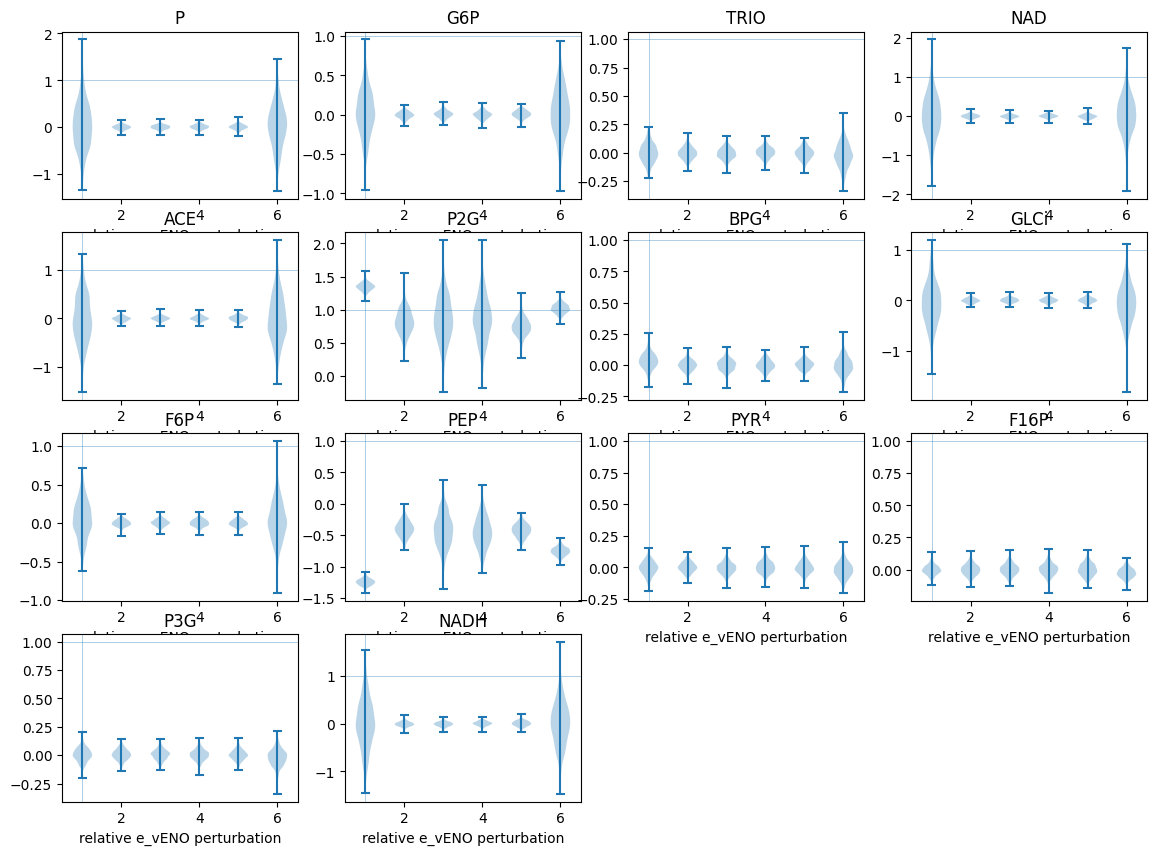

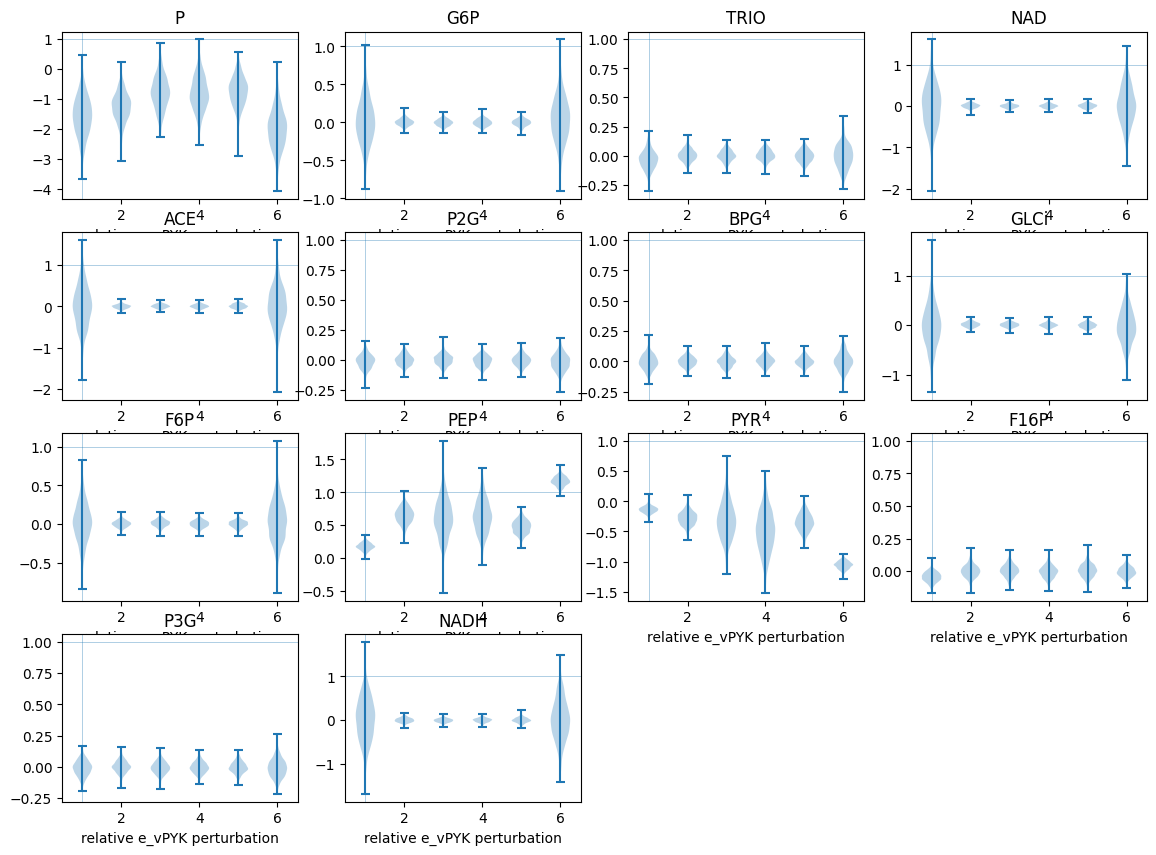

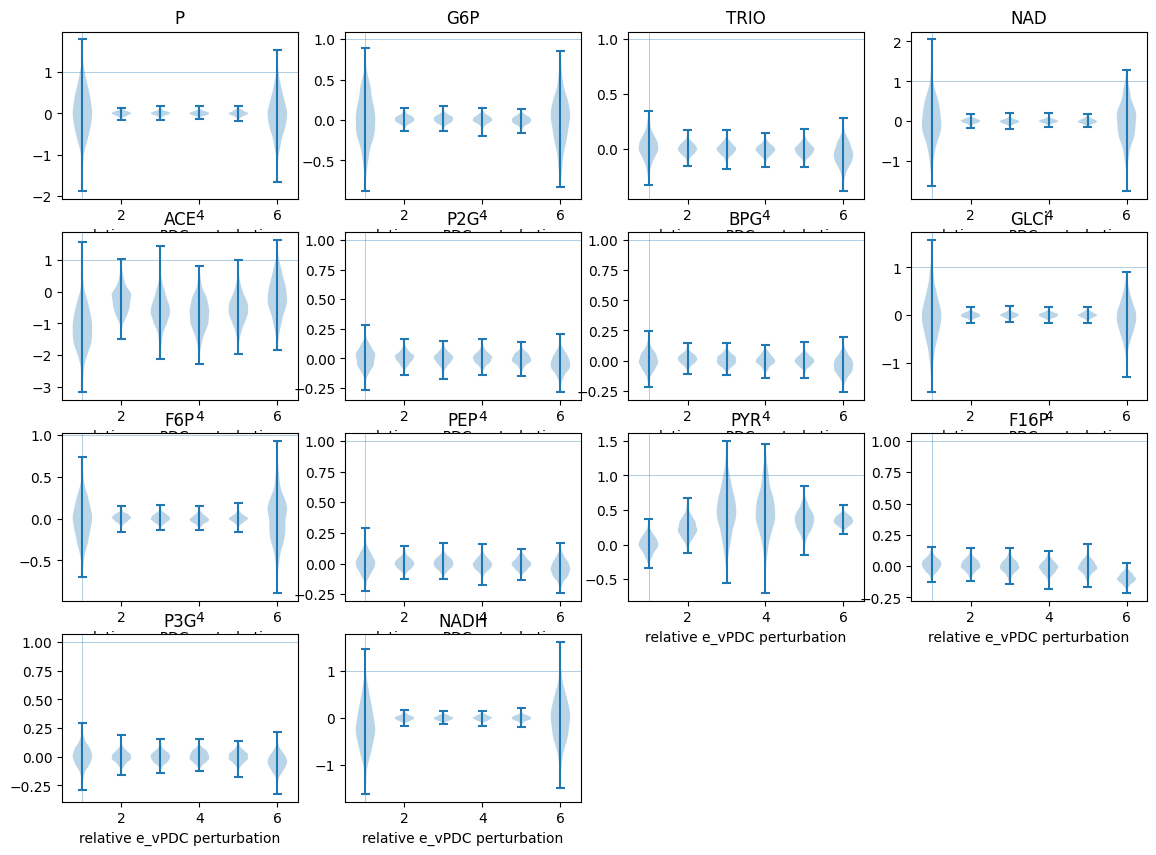

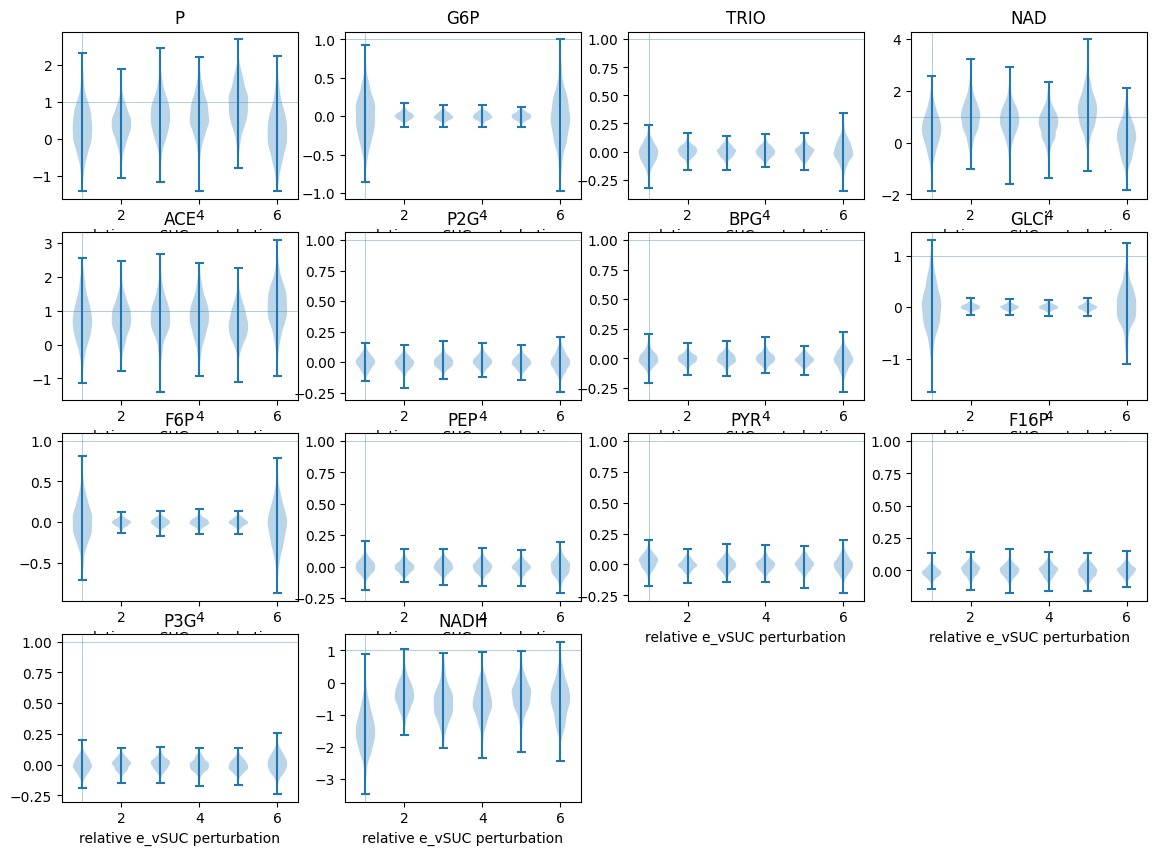

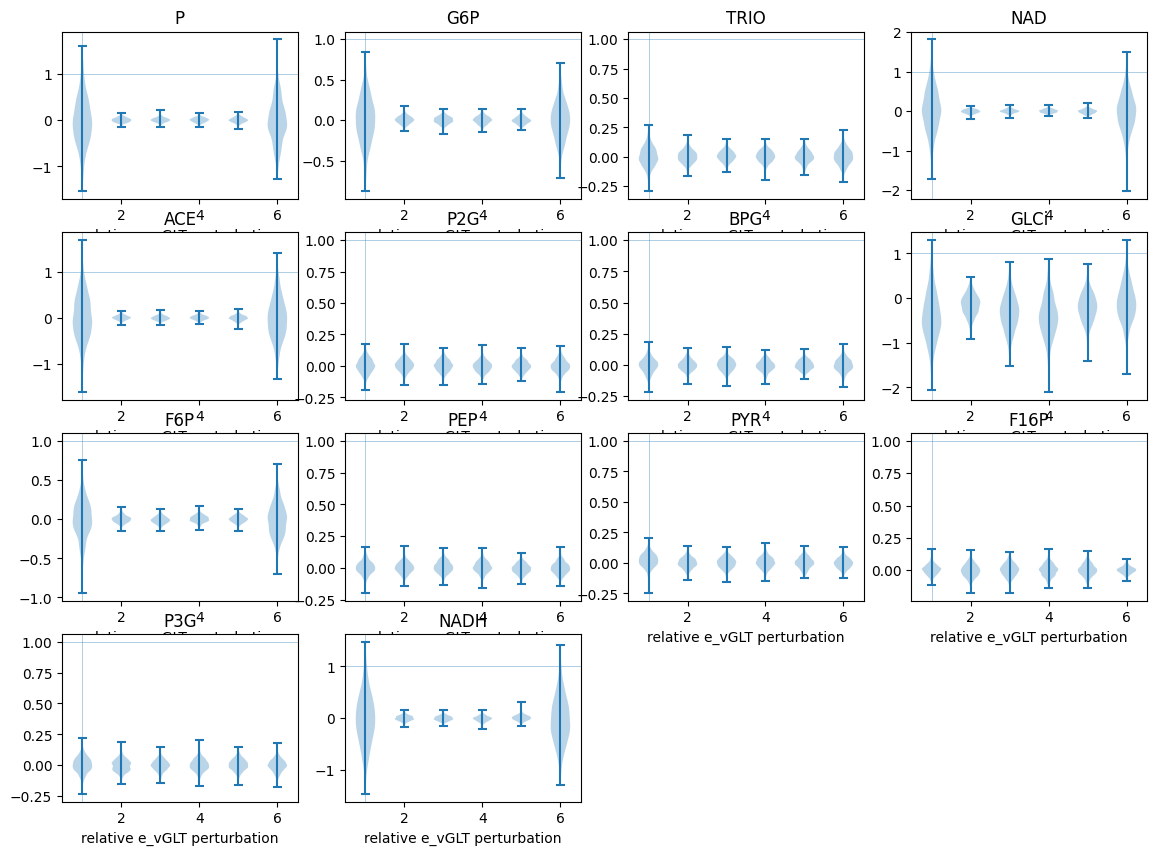

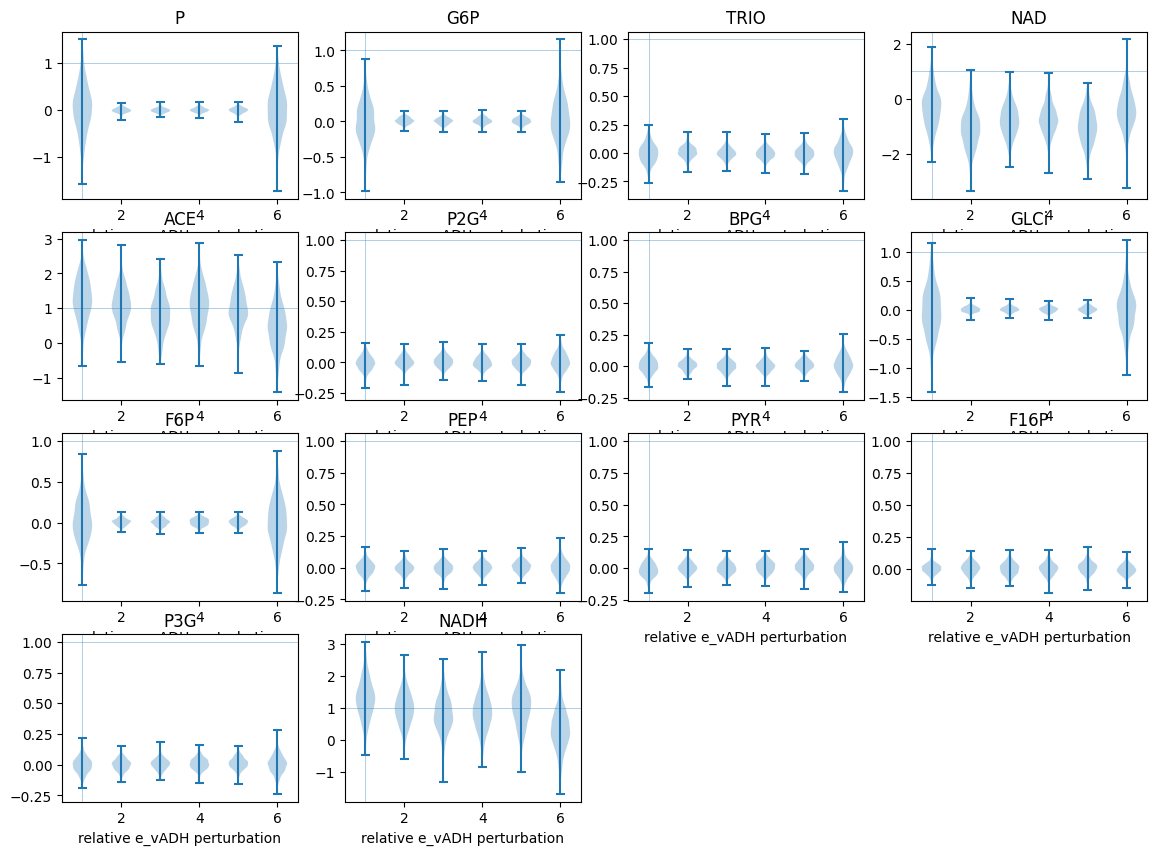

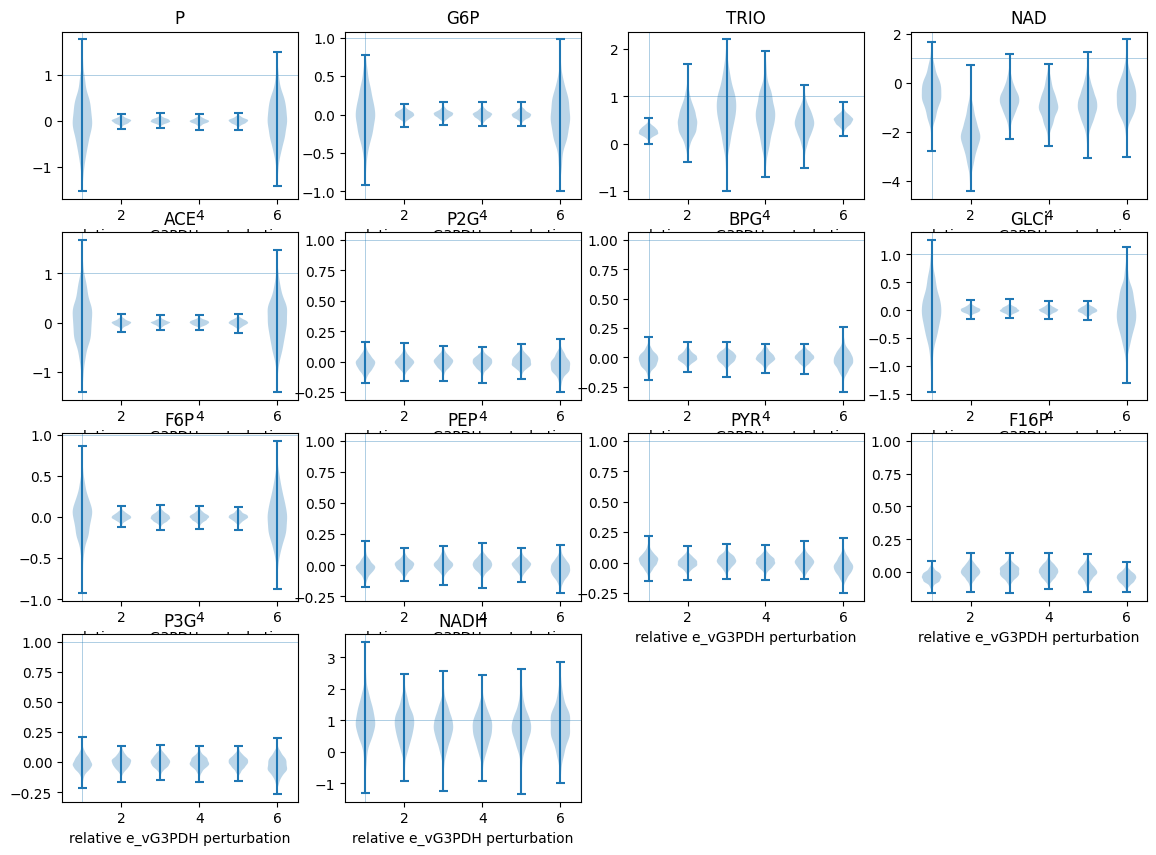

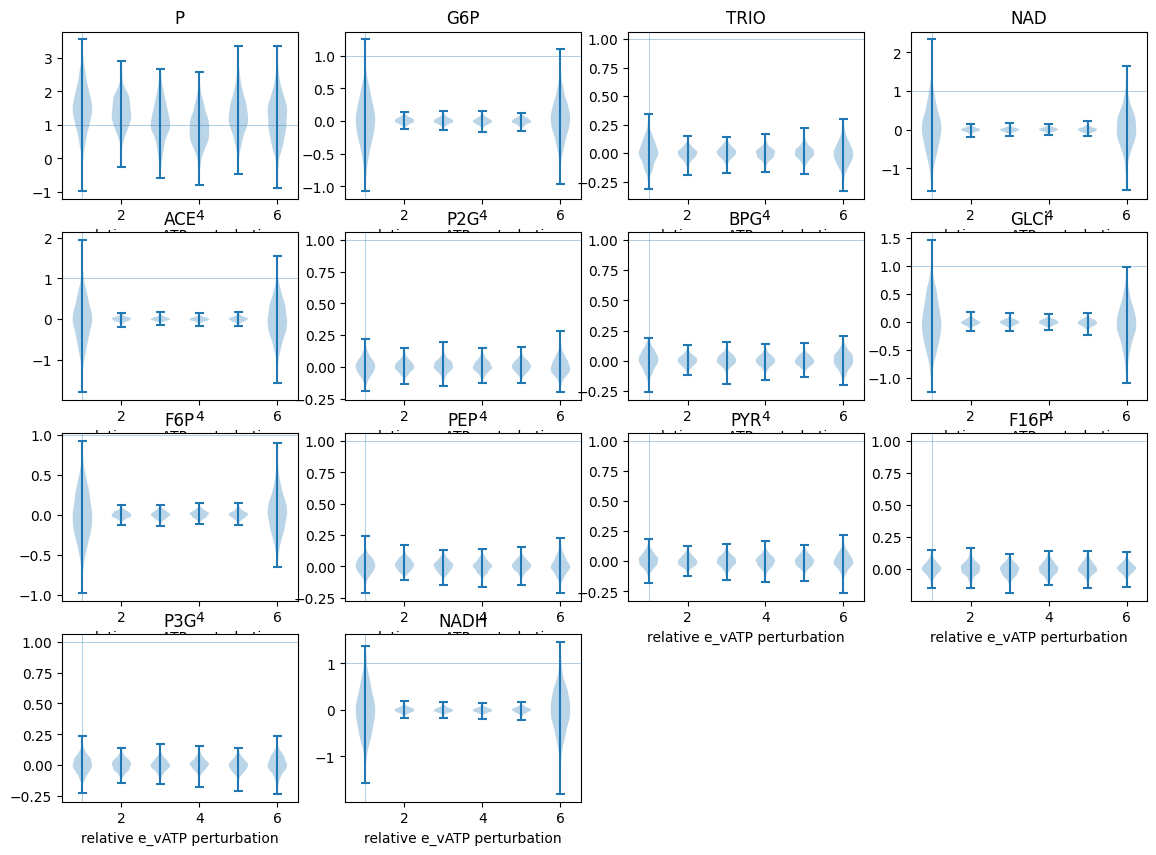

In [26]:
for i,rxn in enumerate(r.getReactionIds()): #['vADH']
    
    fig, ax = plt.subplots(4,4, figsize = (14,10))
    ii=-1
    
    fig.suptitle(f'Ex distributions--{rxn}\n')

    for j,met in enumerate(r.getFloatingSpeciesIds()): # ['TRIO'])
        if j%4==0:
            ii += 1

        met_traces=[]
        for trace in all_traces: 
            met_traces.append(trace[i,j,:])
        met_traces = np.array(met_traces).T

        ax[ii, j%4].violinplot(met_traces)
        # ax[ii, j%4].set_xticks(f'relative e_{rxn} perturbation')
        ax[ii, j%4].axhline(1, linewidth=0.5, zorder=0, alpha=0.5)
        ax[ii, j%4].axvline(x=1, linewidth=0.5, zorder=0, alpha=0.5)
        ax[ii, j%4].set_title(met)
    
    fig.delaxes(ax[3,2]) 
    fig.delaxes(ax[3,3]) 


    

In [43]:
# takig the median peaks can only be done if the distributions are unimodal!
Ex_trace = (trace_vi['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)
Ex_trace.shape

(17, 14, 1000)

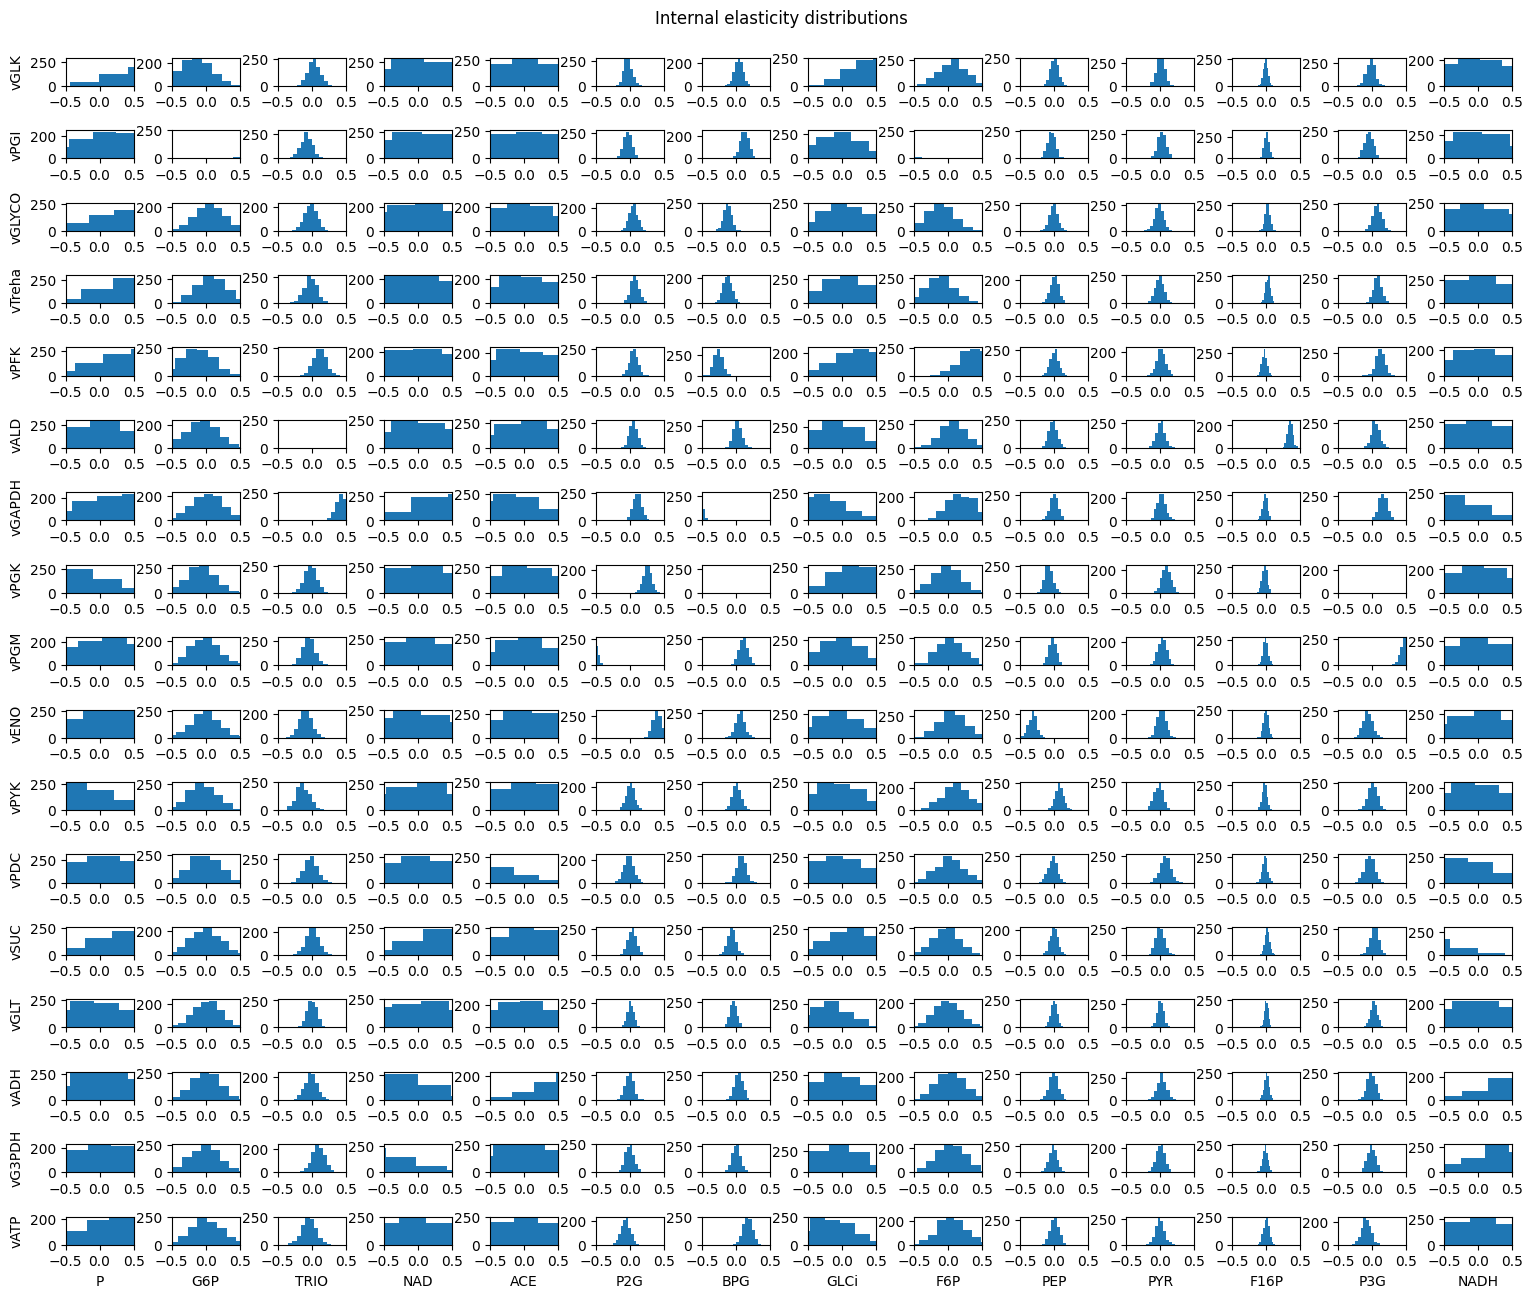

In [44]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(14):
    axs[i,ii].hist(Ex_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

In [45]:
Ex_peaks=[]

for i in range(Ex_trace.shape[0]):
    for ii in range(Ex_trace.shape[1]):
        Ex_peaks.append(np.percentile(Ex_trace[i,ii,:],50))


In [46]:
# these are the elasticity posteriors from Bayesian inference
x = np.array(Ex_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
x[abs(x) < 0.01] = 0

x = x.reshape((17,14))
Ex = pd.DataFrame(x, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())
Ex

P       G6P      TRIO       NAD       ACE       P2G       BPG  \
vGLK    1.010570 -0.151892  0.032459  0.000000  0.016912 -0.029778  0.043943   
vPGI    0.181011  1.213253 -0.072133 -0.011341  0.035234 -0.029337  0.124355   
vGLYCO  0.662317  0.067803 -0.010035 -0.010504 -0.034727  0.051919 -0.120354   
vTreha  0.675493  0.082963 -0.015632  0.000000 -0.017288  0.071511 -0.123350   
vPFK    0.604272 -0.127971  0.120914  0.032174 -0.038097  0.054575 -0.259529   
vALD    0.026562 -0.050575 -0.984839  0.038089  0.038398  0.053732  0.020008   
vGAPDH  0.336389  0.031811  0.457705  0.742306 -0.254788  0.110461 -0.570730   
vPGK   -0.591852 -0.080304 -0.017385 -0.018654  0.052982  0.255227  0.690541   
vPGM    0.087747 -0.019398 -0.037553  0.000000  0.017162 -0.551476  0.108613   
vENO    0.100962  0.000000 -0.091742 -0.010884  0.054034  0.399968  0.059368   
vPYK   -0.466814 -0.048886 -0.130243  0.018495  0.090760  0.000000  0.010871   
vPDC    0.104108 -0.030280 -0.015795  0.032990 -0.879811 -0.014633  0.079326   
vSUC    0.618869  0.000000  0.000000  0.671669  0.101229  0.033853 -0.060140   
vGLT   -0.092585  0.031134  0.000000  0.049736 -0.010995  0.000000 -0.037966   
vADH    0.085401  0.000000 -0.011028 -0.529221  0.832899  0.000000  0.037409   
vG3PDH  0.026556  0.000000  0.099395 -1.015493 -0.016353  0.000000  0.000000   
vATP    0.316450  0.010538 -0.038453  0.000000  0.048373 -0.059534  0.173735   

            GLCi       F6P       PEP       PYR      F16P       P3G      NADH  
vGLK    0.485920  0.067970  0.000000  0.000000  0.000000 -0.020747  0.000000  
vPGI   -0.059982 -0.980369 -0.038734  0.024070  0.000000 -0.051289 -0.048038  
vGLYCO  0.018483 -0.108944  0.000000 -0.015771  0.019600  0.070320  0.000000  
vTreha  0.000000 -0.124744  0.000000  0.000000  0.022763  0.076242 -0.010697  
vPFK    0.282176  0.398845  0.000000  0.012073 -0.028319  0.119083  0.000000  
vALD   -0.102283  0.071920 -0.015153  0.000000  0.350069  0.045154  0.000000  
vGAPDH -0.350738  0.189534  0.000000  0.014863 -0.017314  0.158107 -0.683667  
vPGK    0.182639 -0.020787 -0.079034  0.088543 -0.022881 -0.896168  0.000000  
vPGM   -0.044612  0.032261 -0.020000  0.031039 -0.011705  0.486375  0.000000  
vENO   -0.078939  0.067266 -0.311510  0.019909  0.000000 -0.067534  0.024702  
vPYK   -0.091170  0.118887  0.077511 -0.023179 -0.025748  0.000000 -0.022205  
vPDC   -0.076698  0.026868 -0.016886  0.076016 -0.018857 -0.042918 -0.443921  
vSUC    0.144639 -0.034142  0.000000  0.000000  0.015085  0.030154 -1.106239  
vGLT   -0.207276  0.000000  0.000000  0.000000  0.000000  0.022868 -0.019543  
vADH   -0.049741  0.027953  0.000000  0.023004  0.000000 -0.015690  0.828408  
vG3PDH -0.045036  0.048799 -0.014104  0.000000 -0.016540 -0.013563  0.432012  
vATP   -0.187553  0.047241  0.000000  0.000000  0.000000 -0.092298  0.025813

In [47]:
Ey_trace = (trace_vi['posterior']['Ey']).to_numpy().squeeze().transpose(1, 2, 0)
Ey_trace.shape

(17, 5, 1000)

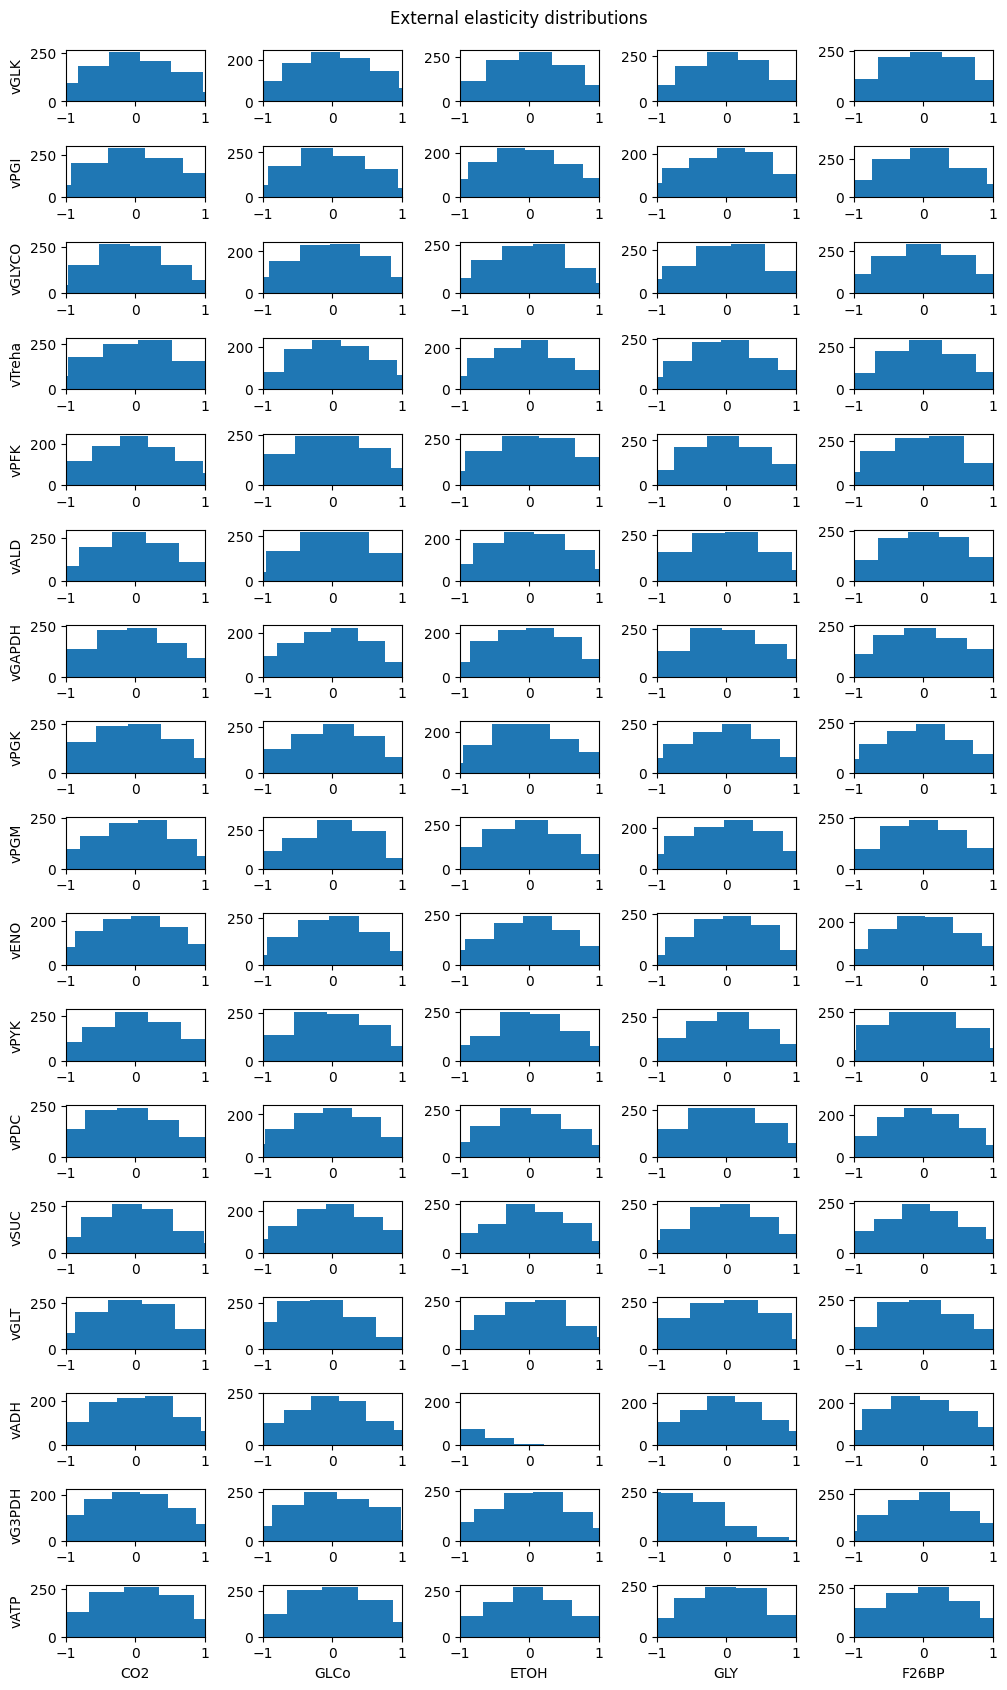

In [48]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,5, figsize=(10, 17)) 

fig.suptitle('External elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(5):
    axs[i,ii].hist(Ey_trace[i,ii,:])
    axs[i,ii].set_xlim([-1,1])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getBoundarySpeciesIds()[ii])

In [49]:
Ey_peaks=[]

for i in range(Ey_trace.shape[0]):
    for ii in range(Ey_trace.shape[1]):
        Ey_peaks.append(np.percentile(Ey_trace[i,ii,:],50))


In [50]:
# elasticities from Bayesian inf posteriors

y = np.array(Ey_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
y[abs(y) < 0.01] = 0

y = y.reshape((17,5))
Ey = pd.DataFrame(y, index=r.getReactionIds(), columns=r.getBoundarySpeciesIds())
Ey

CO2      GLCo      ETOH       GLY     F26BP
vGLK   -0.029989  0.000000  0.032047  0.025128  0.027745
vPGI    0.000000 -0.056348 -0.052186  0.049591  0.000000
vGLYCO -0.052857 -0.010078  0.000000  0.023016  0.000000
vTreha  0.000000  0.016732 -0.022550 -0.017766  0.019491
vPFK    0.000000  0.000000  0.039089  0.000000  0.016448
vALD   -0.028354  0.024641  0.000000  0.000000  0.000000
vGAPDH -0.016083  0.000000 -0.012287  0.014256  0.000000
vPGK   -0.023576  0.039668 -0.023427  0.000000 -0.024658
vPGM    0.000000  0.000000 -0.047608  0.034185  0.000000
vENO    0.000000  0.013618  0.019729  0.074407  0.013195
vPYK    0.000000 -0.011595  0.024980  0.000000  0.000000
vPDC   -0.167908  0.000000 -0.039737 -0.021622 -0.025831
vSUC   -0.032827  0.000000  0.012308  0.020678 -0.019720
vGLT   -0.053199 -0.288377  0.000000  0.000000 -0.048838
vADH    0.028146 -0.033854 -1.905218 -0.011453 -0.043233
vG3PDH -0.029311  0.000000  0.032301 -0.868455  0.048504
vATP    0.026636  0.000000 -0.016886  0.000000  0.040195

In [51]:
enzymes = [i for i in data.columns if 'e_' in i]

In [52]:
a = data[enzymes].apply(lambda row: row[row != 1].index, axis=1)
pt_enz = [i[0] for i in a[1:]]

a = data[data[enzymes] != 1].values.flatten()
pt_lvls = a[~np.isnan(a)]

C:\Users\user\AppData\Local\Temp\ipykernel_23988\1020810182.py:2: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [53]:
# zip pt_enz and pt_lvls together and then assign them as the column names
enzPtLvls = [x +'|'+ str(y) for x, y in zip(pt_enz, pt_lvls)]

In [54]:
# get the real values
real_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_values = real_values.div(real_values.iloc[0])
rel_real_values.drop(rel_real_values.index[0], inplace=True)
rel_real_values.columns = r.getReactionIds()
rel_real_values = rel_real_values.transpose()
rel_real_values.columns = enzPtLvls
rel_real_values

e_vGLK|0.9  e_vGLK|1.1  e_vPGI|0.9  e_vPGI|1.1  e_vGLYCO|0.9  \
vGLK      0.980507    1.012952    0.999750    1.000193      1.002050   
vPGI      0.977785    1.014761    0.999715    1.000220      1.010093   
vGLYCO    1.000000    1.000000    1.000000    1.000000      0.900000   
vTreha    1.000000    1.000000    1.000000    1.000000      1.000000   
vPFK      0.977785    1.014761    0.999715    1.000220      1.010093   
vALD      0.977785    1.014761    0.999715    1.000220      1.010093   
vGAPDH    0.976366    1.015693    0.999697    1.000234      1.010641   
vPGK      0.976366    1.015693    0.999697    1.000234      1.010641   
vPGM      0.976366    1.015693    0.999697    1.000234      1.010641   
vENO      0.976366    1.015693    0.999697    1.000234      1.010641   
vPYK      0.976366    1.015693    0.999697    1.000234      1.010641   
vPDC      0.976366    1.015693    0.999697    1.000234      1.010641   
vSUC      0.988426    1.007765    0.999851    1.000115      1.005985   
vGLT      0.980507    1.012952    0.999750    1.000193      1.002050   
vADH      0.975687    1.016140    0.999688    1.000241      1.010904   
vG3PDH    0.988426    1.007765    0.999851    1.000115      1.005985   
vATP      0.966324    1.022331    0.999568    1.000334      1.029059   

        e_vGLYCO|1.1  e_vTreha|0.9  e_vTreha|1.1  e_vPFK|0.9  e_vPFK|1.1  \
vGLK        0.997776      1.001431      0.998486    0.999806    1.000146   
vPGI        0.989709      1.007836      0.992069    0.999779    1.000166   
vGLYCO      1.100000      1.000000      1.000000    1.000000    1.000000   
vTreha      1.000000      0.900000      1.100000    1.000000    1.000000   
vPFK        0.989709      1.007836      0.992069    0.999779    1.000166   
vALD        0.989709      1.007836      0.992069    0.999779    1.000166   
vGAPDH      0.989129      1.008280      0.991611    0.999765    1.000177   
vPGK        0.989129      1.008280      0.991611    0.999765    1.000177   
vPGM        0.989129      1.008280      0.991611    0.999765    1.000177   
vENO        0.989129      1.008280      0.991611    0.999765    1.000177   
vPYK        0.989129      1.008280      0.991611    0.999765    1.000177   
vPDC        0.989129      1.008280      0.991611    0.999765    1.000177   
vSUC        0.994055      1.004513      0.995505    0.999884    1.000087   
vGLT        0.997776      1.001431      0.998486    0.999806    1.000146   
vADH        0.988852      1.008492      0.991391    0.999758    1.000182   
vG3PDH      0.994055      1.004513      0.995505    0.999884    1.000087   
vATP        0.970556      1.020137      0.979678    0.999665    1.000251   

        e_vALD|0.9  e_vALD|1.1  e_vGAPDH|0.9  e_vGAPDH|1.1  e_vPGK|0.9  \
vGLK      0.999960    1.000031      0.998572      1.001237    0.999958   
vPGI      0.999954    1.000036      0.998372      1.001410    0.999952   
vGLYCO    1.000000    1.000000      1.000000      1.000000    1.000000   
vTreha    1.000000    1.000000      1.000000      1.000000    1.000000   
vPFK      0.999954    1.000036      0.998372      1.001410    0.999952   
vALD      0.999954    1.000036      0.998372      1.001410    0.999952   
vGAPDH    0.999951    1.000038      0.994962      1.004513    0.999849   
vPGK      0.999951    1.000038      0.994962      1.004513    0.999849   
vPGM      0.999951    1.000038      0.994962      1.004513    0.999849   
vENO      0.999951    1.000038      0.994962      1.004513    0.999849   
vPYK      0.999951    1.000038      0.994962      1.004513    0.999849   
vPDC      0.999951    1.000038      0.994962      1.004513    0.999849   
vSUC      0.999976    1.000019      1.023951      0.978139    1.000723   
vGLT      0.999960    1.000031      0.998572      1.001237    0.999958   
vADH      0.999950    1.000039      0.993328      1.005999    0.999800   
vG3PDH    0.999976    1.000019      1.023951      0.978139    1.000723   
vATP      0.999931    1.000054      0.982581      1.015760    0.999476   

        e

Text(-9, 4, 'r = 0.491')

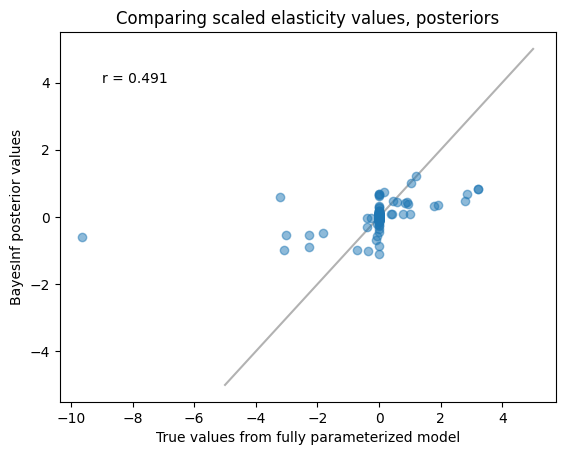

In [55]:
plt.scatter(Ex_values, x, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-9,4,'r = ' + str((stats.pearsonr(Ex_values.flatten(), x.flatten())[0]).round(3)))

# the dot all the way to the left is P on PGK

## Plotting MCC and FCC comparisons

In [56]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [57]:
postCCC, postFCC = util.elasticity_to_CCC(BIOMD64, Ex)  
postCCC = pd.DataFrame(postCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
postFCC = pd.DataFrame(postFCC) #, index=r.getReactionIds(), columns=r.getReactionIds())
postFCC.columns = r.getReactionIds()
postFCC.index = r.getReactionIds()
postFCC

vGLK      vPGI    vGLYCO    vTreha      vPFK      vALD    vGAPDH  \
vGLK    0.338550  0.045567  0.120855  0.097565 -0.453093  0.070023  0.467803   
vPGI    0.418637  0.056143  0.046011  0.037359 -0.493628  0.073805  0.478991   
vGLYCO -0.291755 -0.024146  1.173890  0.140757 -0.329593  0.066304  0.556549   
vTreha -0.164130 -0.037719  0.010633  1.013751  0.045733  0.013718  0.176576   
vPFK    0.418637  0.056143  0.046011  0.037359 -0.493628  0.073805  0.478991   
vALD    0.418637  0.056143  0.046011  0.037359 -0.493628  0.073805  0.478991   
vGAPDH  0.467410  0.063283  0.066801  0.053088 -0.572655  0.082855  0.571135   
vPGK    0.467410  0.063283  0.066801  0.053088 -0.572655  0.082855  0.571135   
vPGM    0.467410  0.063283  0.066801  0.053088 -0.572655  0.082855  0.571135   
vENO    0.467410  0.063283  0.066801  0.053088 -0.572655  0.082855  0.571135   
vPYK    0.467410  0.063283  0.066801  0.053088 -0.572655  0.082855  0.571135   
vPDC    0.467410  0.063283  0.066801  0.053088 -0.572655  0.082855  0.571135   
vSUC    0.052895  0.002606 -0.109887 -0.080586  0.098991  0.005942 -0.211984   
vGLT    0.338550  0.045567  0.120855  0.097565 -0.453093  0.070023  0.467803   
vADH    0.490766  0.066701  0.076757  0.060620 -0.610500  0.087189  0.615261   
vG3PDH  0.052895  0.002606 -0.109887 -0.080586  0.098991  0.005942 -0.211984   
vATP    0.789631  0.107814 -0.017092  0.010630 -0.920153  0.120904  0.910341   

            vPGK      vPGM      vENO      vPYK      vPDC      vSUC      vGLT  \
vGLK    0.095307  0.203143  0.144547  0.831858  0.006147 -0.130255 -1.178783   
vPGI    0.057457  0.169223  0.153555  0.834851  0.038671 -0.124954 -1.135042   
vGLYCO  0.369289  0.494726  0.127797  1.071948 -0.120931 -0.154143 -2.383816   
vTreha  0.362775  0.385263  0.020334  0.483515 -0.359109 -0.185807 -0.377340   
vPFK    0.057457  0.169223  0.153555  0.834851  0.038671 -0.124954 -1.135042   
vALD    0.057457  0.169223  0.153555  0.834851  0.038671 -0.124954 -1.135042   
vGAPDH  0.066902  0.199514  0.181541  0.967535  0.041826 -0.179703 -1.422898   
vPGK    0.066902  0.199514  0.181541  0.967535  0.041826 -0.179703 -1.422898   
vPGM    0.066902  0.199514  0.181541  0.967535  0.041826 -0.179703 -1.422898   
vENO    0.066902  0.199514  0.181541  0.967535  0.041826 -0.179703 -1.422898   
vPYK    0.066902  0.199514  0.181541  0.967535  0.041826 -0.179703 -1.422898   
vPDC    0.066902  0.199514  0.181541  0.967535  0.041826 -0.179703 -1.422898   
vSUC   -0.013371 -0.057924 -0.056311 -0.160138  0.015008  0.285603  1.023559   
vGLT    0.095307  0.203143  0.144547  0.831858  0.006147 -0.130255 -1.178783   
vADH    0.071425  0.214020  0.194943  1.031076  0.043337 -0.205922 -1.560748   
vG3PDH -0.013371 -0.057924 -0.056311 -0.160138  0.015008  0.285603  1.023559   
vATP    0.029888  0.241566  0.295089  1.431014  0.109474 -0.363160 -2.323766   

            vADH    vG3PDH      vATP  
vGLK    0.022562  0.349215 -0.031011  
vPGI    0.053433  0.354872 -0.019383  
vGLYCO -0.076375  0.437444 -0.057946  
vTreha -0.351238  0.147767 -0.184723  
vPFK    0.053433  0.354872 -0.019383  
vALD    0.053433  0.354872 -0.019383  
vGAPDH  0.063978  0.336961  0.012429  
vPGK    0.063978  0.336961  0.012429  
vPGM    0.063978  0.336961  0.012429  
vENO    0.063978  0.336961  0.012429  
vPYK    0.063978  0.336961  0.012429  
vPDC    0.063978  0.336961  0.012429  
vSUC   -0.025646  0.489183 -0.257941  
vGLT    0.022562  0.349215 -0.031011  
vADH    0.069028  0.328384  0.027663  
vG3PDH -0.025646  0.489183 -0.257941  
vATP    0.154006  0.279812  0.144004

Text(-4, 4, 'r = 0.686')

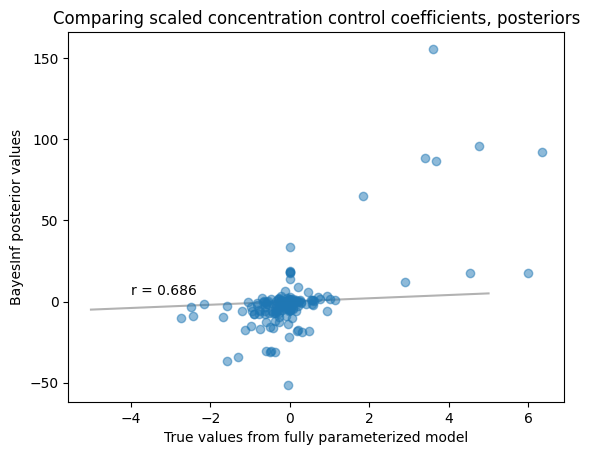

In [58]:
fig = plt.figure()

plt.scatter(gtCCC, postCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled concentration control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), postCCC.to_numpy().flatten())[0]).round(3)))

Text(-1, 2, 'r = -0.453')

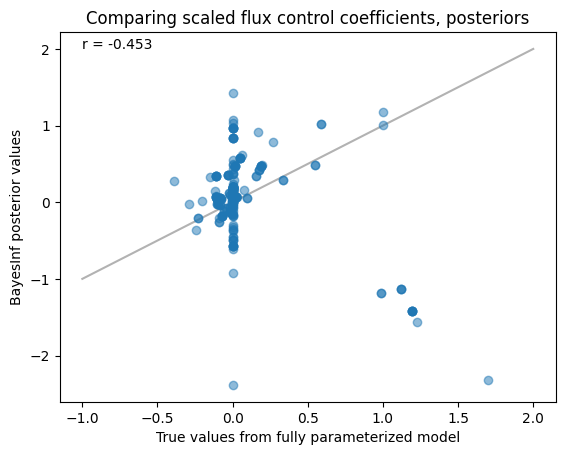

In [59]:
fig = plt.figure()

plt.scatter(gtFCC, postFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), postFCC.to_numpy().flatten())[0]).round(3)))

## Pairwise comparison of FCC values

In [ ]:
def plot_pairwise_FCCs(yield_enzyme):
    priors = pd.DataFrame(visFCC[yield_enzyme])
    priors['distribution'] = ['prior']* len(priors)
    posteriors = pd.DataFrame(postFCC[yield_enzyme])
    posteriors['distribution'] = ['posterior']* len(posteriors)
    paired = pd.concat([priors, posteriors]).reset_index()
    pv_tbl = paired.pivot('index', 'distribution', yield_enzyme)

    fig = pv_tbl[['prior', 'posterior']].plot(kind='bar', colormap='winter')
    plt.title(f'FCCs for {yield_enzyme}, before & after Bayesian inference')

    for i,val in enumerate(gtFCC[yield_enzyme].sort_index()):
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[yield_enzyme]), # From the left
                xmax = (i+0.8)/len(gtFCC[yield_enzyme]), 
                c='red') # To the right

In [ ]:
for i,rxn in enumerate(r.getReactionIds()):
    plot_pairwise_FCCs(rxn)

## Ranking FCC values

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



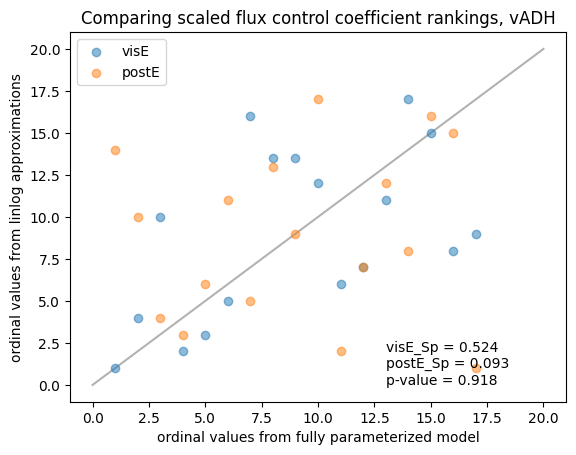

In [60]:
def rank_FCC_values(yield_enzyme): 
    FCCrankings = pd.concat([gtFCC.loc[yield_enzyme].rank(), visFCC.loc[yield_enzyme].rank(), postFCC.loc[yield_enzyme].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    fig = plt.figure()

    plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
    plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
    plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
    plt.title(f'Comparing scaled flux control coefficient rankings, {yield_enzyme}')
    plt.xlabel('ordinal values from fully parameterized model')
    plt.ylabel('ordinal values from linlog approximations')

    plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
    plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
    plt.text(13,0,'Wilcoxon p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))
    plt.legend()

    FCCrankings['visE_dif'] = FCCrankings['visE'] - FCCrankings['gt']
    FCCrankings['postE_dif'] = FCCrankings['postE'] - FCCrankings['gt']
    FCCrankings.sort_values('gt')[['visE_dif','postE_dif']].plot(kind='bar', align='edge', width=0.7, alpha=0.7)
    plt.title(f'Rankings of FCC values for {yield_enzyme} predicted by Bayesian inference')
    plt.xlabel("reactions in order of gt FCC ranking")
    plt.ylabel("FCC ranking")

    return FCCrankings.sort_values('gt')

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



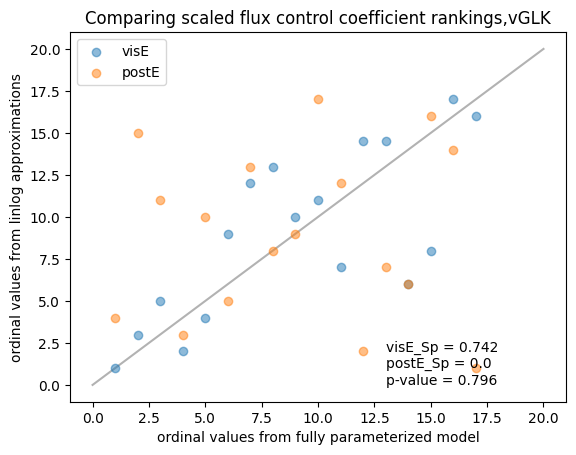

In [61]:
rank_FCC_values('vADH')
rank_FCC_values('vPGI')
rank_FCC_values('vENO')

## Distribution of FCC Sp. correlation coefficients

In [63]:
visE_r=[]
postE_r=[]

for i in r.getReactionIds():        
    FCCrankings = pd.concat([gtFCC.loc[i].rank(), visFCC.loc[i].rank(), postFCC.loc[i].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    visE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0])
    postE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0])


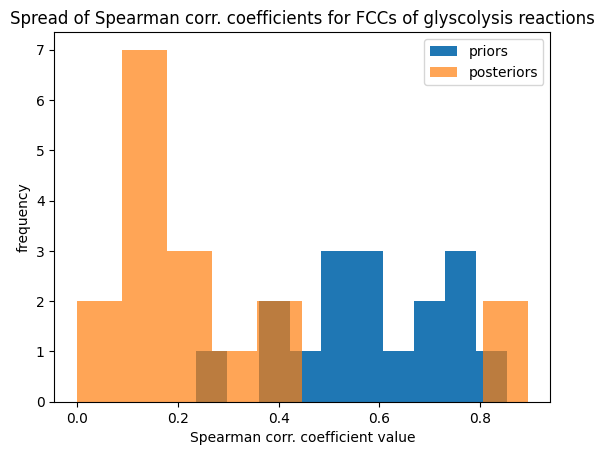

In [64]:
plt.hist(visE_r, label='priors')
plt.hist(postE_r, alpha=0.7, label='posteriors')
plt.legend()
plt.xlabel('Spearman corr. coefficient value')
plt.ylabel('frequency')
plt.title('Spread of Spearman corr. coefficients for FCCs of glyscolysis reactions')

plt.show()


# Solving for steady state concentrations using enzyme perturbation data

In [2]:
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/enzymeCompilation.csv'
df = pd.read_csv(data_file)
# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index) 

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

5.935978122618177e-12

In [ ]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)

## Solving for steady state internal metabolite concentrations (X)

In [4]:
enzymes = [i for i in data.columns if 'e_' in i]

a = data[enzymes].apply(lambda row: row[row != 1].index, axis=1)
pt_enz = [i[0] for i in a[1:]]
pt_enz.insert(0, 'e_vPGK')

C:\Users\user\AppData\Local\Temp\ipykernel_21184\4088482062.py:4: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [5]:
a = data[data[enzymes] != 1].values.flatten()
# a = data[enzymes].values.flatten()
pt_lvls = a[~np.isnan(a)]
pt_lvls = list(pt_lvls)
pt_lvls.insert(0, 1.0)

# zip pt_enz and pt_lvls together and then assign them as the column names
enzPtLvls = [x +'|'+ str(y) for x, y in zip(pt_enz, pt_lvls)]

In [6]:
# get the real flux values
real_flux_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_flux_values = real_flux_values.div(real_flux_values.iloc[0])
# rel_real_flux_values.drop(rel_real_flux_values.index[0], inplace=True)
rel_real_flux_values.columns = r.getReactionIds()
rel_real_flux_values = rel_real_flux_values.transpose()
rel_real_flux_values.columns = enzPtLvls

In [7]:
# get the real inmet values
real_inmet_values = data[[i for i in data.columns if i in r.getFloatingSpeciesIds()]]
rel_real_inmet_values = real_inmet_values.div(real_inmet_values.iloc[0])
# rel_real_inmet_values.drop(rel_real_inmet_values.index[0], inplace=True)
rel_real_inmet_values = rel_real_inmet_values.transpose()
rel_real_inmet_values.columns = enzPtLvls
rel_real_inmet_values

e_vPGK|1.0  e_vGLK|0.9  e_vGLK|1.1  e_vPGI|0.9  e_vPGI|1.1  \
P            1.0    0.981102    1.012340    0.999760    1.000185   
G6P          1.0    0.915856    1.062600    1.095768    0.926054   
TRIO         1.0    0.964675    1.024681    0.999533    1.000361   
NAD          1.0    0.999887    1.000075    0.999999    1.000001   
ACE          1.0    0.988426    1.007765    0.999851    1.000115   
P2G          1.0    0.931656    1.050402    0.999068    1.000721   
BPG          1.0    0.884451    1.088375    0.998389    1.001244   
GLCi         1.0    1.275019    0.822960    1.003465    0.997325   
F6P          1.0    0.889588    1.082729    0.998479    1.001177   
PEP          1.0    0.912582    1.065984    0.998792    1.000935   
PYR          1.0    0.945724    1.039756    0.999263    1.000570   
F16P         1.0    0.932066    1.048850    0.999087    1.000706   
P3G          1.0    0.936616    1.046442    0.999139    1.000666   
NADH         1.0    1.003918    0.997385    1.000050    0.999961   

      e_vGLYCO|0.9  e_vGLYCO|1.1  e_vTreha|0.9  e_vTreha|1.1  e_vPFK|0.9  \
P         1.016028      0.983496      1.011134      0.988638    0.999814   
G6P       1.060964      0.944343      1.043482      0.959234    1.074261   
TRIO      1.019700      0.981049      1.014680      0.985711    0.999638   
NAD       1.000071      0.999931      1.000052      0.999949    0.999999   
ACE       1.005985      0.994055      1.004513      0.995505    0.999884   
P2G       1.043488      0.959794      1.031735      0.969992    0.999277   
BPG       1.094467      0.915913      1.066104      0.939124    0.998750   
GLCi      0.971681      1.030843      0.980221      1.020988    1.002687   
F6P       1.086807      0.921304      1.061102      0.942995    1.123996   
PEP       1.064690      0.941533      1.046002      0.957185    0.999063   
PYR       1.026599      0.974265      1.020568      0.980019    0.999428   
F16P      1.037958      0.964015      1.028371      0.972702    0.999292   
P3G       1.039000      0.963712      1.028632      0.972806    0.999332   
NADH      0.997514      1.002408      0.998204      1.001762    1.000039   

      e_vPFK|1.1  e_vALD|0.9  e_vALD|1.1  e_vGAPDH|0.9  e_vGAPDH|1.1  \
P       1.000140    0.999962    1.000030      0.990269      1.008725   
G6P     0.944260    1.015330    0.988048      1.023501      0.983821   
TRIO    1.000272    0.999925    1.000058      1.109371      0.913130   
NAD     1.000001    1.000000    1.000000      1.000711      0.999320   
ACE     1.000087    0.999976    1.000019      1.023951      0.978139   
P2G     1.000543    0.999851    1.000116      0.978715      1.020216   
BPG     1.000938    0.999742    1.000200      0.951653      1.046921   
GLCi    0.997983    1.000555    0.999568      1.019794      0.982896   
F6P     0.906949    1.025595    0.980047      1.041463      0.971095   
PEP     1.000705    0.999806    1.000151      0.967394      1.031373   
PYR     1.000430    0.999882    1.000092      0.987900      1.011103   
F16P    1.000532    1.060552    0.953532      1.187275      0.864676   
P3G     1.000502    0.999862    1.000108      0.981025      1.017955   
NADH    0.999971    1.000008    0.999994      0.975267      1.023632   

      e_vPGK|0.9  e_vPGK|1.1  e_vPGM|0.9  e_vPGM|1.1  e_vENO|0.9  e_vENO|1.1  \
P       0.999709    1.000239    0.999761    1.000194    0.999313    1.000506   
G6P     1.000617    0.999498    1.000505    0.999592    1.001464    0.998939   
TRIO    1.003071    0.997492    1.002517    0.997958    1.007270    0.994686   
NAD     1.000022    0.999982    1.000018    0.999985    1.000052    0.999962   
ACE     1.000723    0.999407    1.000593    0.999517    1.001707    0.998741   
P2G     0.999345    1.000538    0.999462    1.000438    1.141534    0.897163   
BPG     1.037573    0.969339    1.030797    0.975037    1.088997    0.935059   
GLCi    1.000581    0.999524    1.000476    0.999613    1.001373    0.998991   
F6P     1.001094    0.999110    1.000897   

In [8]:
# get the real exmet values
real_exmet_values = data[[i for i in data.columns if i in r.getBoundarySpeciesIds()]]
rel_real_exmet_values = real_exmet_values.div(real_exmet_values.iloc[0])
# rel_real_exmet_values.drop(rel_real_exmet_values.index[0], inplace=True)
rel_real_exmet_values = rel_real_exmet_values.transpose()
rel_real_exmet_values.columns = enzPtLvls
rel_real_exmet_values

e_vPGK|1.0  e_vGLK|0.9  e_vGLK|1.1  e_vPGI|0.9  e_vPGI|1.1  \
CO2           1.0         1.0         1.0         1.0         1.0   
GLCo          1.0         1.0         1.0         1.0         1.0   
ETOH          1.0         1.0         1.0         1.0         1.0   
GLY           1.0         1.0         1.0         1.0         1.0   
F26BP         1.0         1.0         1.0         1.0         1.0   

       e_vGLYCO|0.9  e_vGLYCO|1.1  e_vTreha|0.9  e_vTreha|1.1  e_vPFK|0.9  \
CO2             1.0           1.0           1.0           1.0         1.0   
GLCo            1.0           1.0           1.0           1.0         1.0   
ETOH            1.0           1.0           1.0           1.0         1.0   
GLY             1.0           1.0           1.0           1.0         1.0   
F26BP           1.0           1.0           1.0           1.0         1.0   

       e_vPFK|1.1  e_vALD|0.9  e_vALD|1.1  e_vGAPDH|0.9  e_vGAPDH|1.1  \
CO2           1.0         1.0         1.0           1.0           1.0   
GLCo          1.0         1.0         1.0           1.0           1.0   
ETOH          1.0         1.0         1.0           1.0           1.0   
GLY           1.0         1.0         1.0           1.0           1.0   
F26BP         1.0         1.0         1.0           1.0           1.0   

       e_vPGK|0.9  e_vPGK|1.1  e_vPGM|0.9  e_vPGM|1.1  e_vENO|0.9  e_vENO|1.1  \
CO2           1.0         1.0         1.0         1.0         1.0         1.0   
GLCo          1.0         1.0         1.0         1.0         1.0         1.0   
ETOH          1.0         1.0         1.0         1.0         1.0         1.0   
GLY           1.0         1.0         1.0         1.0         1.0         1.0   
F26BP         1.0         1.0         1.0         1.0         1.0         1.0   

       e_vPYK|0.9  e_vPYK|1.1  e_vPDC|0.9  e_vPDC|1.1  e_vSUC|0.9  e_vSUC|1.1  \
CO2           1.0         1.0         1.0         1.0         1.0         1.0   
GLCo          1.0         1.0         1.0         1.0         1.0         1.0   
ETOH          1.0         1.0         1.0         1.0         1.0         1.0   
GLY           1.0         1.0         1.0         1.0         1.0         1.0   
F26BP         1.0         1.0         1.0         1.0         1.0         1.0   

       e_vGLT|0.9  e_vGLT|1.1  e_vADH|0.9  e_vADH|1.1  e_vG3PDH|0.9  \
CO2           1.0         1.0         1.0         1.0           1.0   
GLCo          1.0         1.0         1.0         1.0           1.0   
ETOH          1.0         1.0         1.0         1.0           1.0   
GLY           1.0         1.0         1.0         1.0           1.0   
F26BP         1.0         1.0         1.0         1.0           1.0   

       e_vG3PDH|1.1  e_vATP|0.9  e_vATP|1.1  e_vGLK|0.887  e_vGLK|1.113  \
CO2             1.0         1.0         1.0           1.0           1.0   
GLCo            1.0         1.0         1.0           1.0           1.0   
ETOH            1.0         1.0         1.0           1.0           1.0   
GLY             1.0         1.0         1.0           1.0           1.0   
F26BP           1.0         1.0         1.0           1.0           1.0   

       e_vPGI|0.887  e_vPGI|1.113  e_vGLYCO|0.887  e_vGLYCO|1.113  \
CO2             1.0           1.0             1.0             1.0   
GLCo            1.0           1.0             1.0             1.0   
ETOH            1.0           1.0             1.0             1.0   
GLY             1.0           1.0             1.0             1.0   
F26BP           1.0           1.0             1.0             1.0   

       e_vTreha|0.887  e_vTreha|1.113  e_vPFK|0.887  e_vPFK|1.113  \
CO2               1.0             1.0           1.0           1.0   
GLCo              1.0             1.0           1.0           1.0   
ETOH              1.0             1.0           1.0           1.0   
GLY               1.0             1.0           1.0           1.0   
F26BP             1.0             1.0           1.0           1.0   

       e

Setting up approximation calculation with simulated values

In [9]:
N = BIOMD64.N
Ex = r.getScaledElasticityMatrix()

a = r.getBoundarySpeciesIds()
b = r.getReactionIds()
c=[]
for i in b: 
    for ii in a: 
        c.append(r.getUnscaledParameterElasticity(i, ii) * r[ii]/r[i])
Ey = np.array(c).reshape((len(b),len(a)))


In [10]:
pt_lvls = list(set([i.split('|')[1] for i in rel_real_flux_values.columns]))
pt_lvls.sort()

In [11]:
enzyme_perts = data[[i for i in data.columns if 'e_' in i]]
enzyme_perts = enzyme_perts.transpose()
enzyme_perts.columns = enzPtLvls
enzyme_perts.shape

(17, 642)

In [12]:
# data for graphing
x_data = data[r.getFloatingSpeciesIds()]
x_star = x_data.iloc[0].values
x_star[x_star == 0] = 1e-6
xn = x_data.divide(x_star)

y_data = data[r.getBoundarySpeciesIds()]
y_star = y_data.iloc[0].values
y_star[y_star == 0] = 1e-6
yn = y_data.divide(y_star)

vn = real_flux_values
e_hat = enzyme_perts.values.T

In [15]:
n_exp = len(data)
e_hat = enzyme_perts.values.T# [:,:]
v_star = BIOMD64.v_star[np.newaxis,:]
product = (e_hat*v_star)

def my_func(a): 
    return np.diag(a)

c = np.apply_along_axis(my_func, 1, product)

N_rep = N.reshape((-1, *N.shape)).repeat(642, axis=0) # (642, 14, 17)

A = (N_rep@c@Ex) # (642, 14, 14)
arr = ((np.ones((len(N.T),n_exp)) + (Ey @ np.log(yn.T)))).values
arr = arr.T[:,:, np.newaxis]
b = -(N_rep@c) @ arr # (642, 14, 642)

Xss = []
for i in range(n_exp): 
    Xss.append(np.linalg.pinv(A[i])@b[i])


### Graphing the steady state internal concentrations

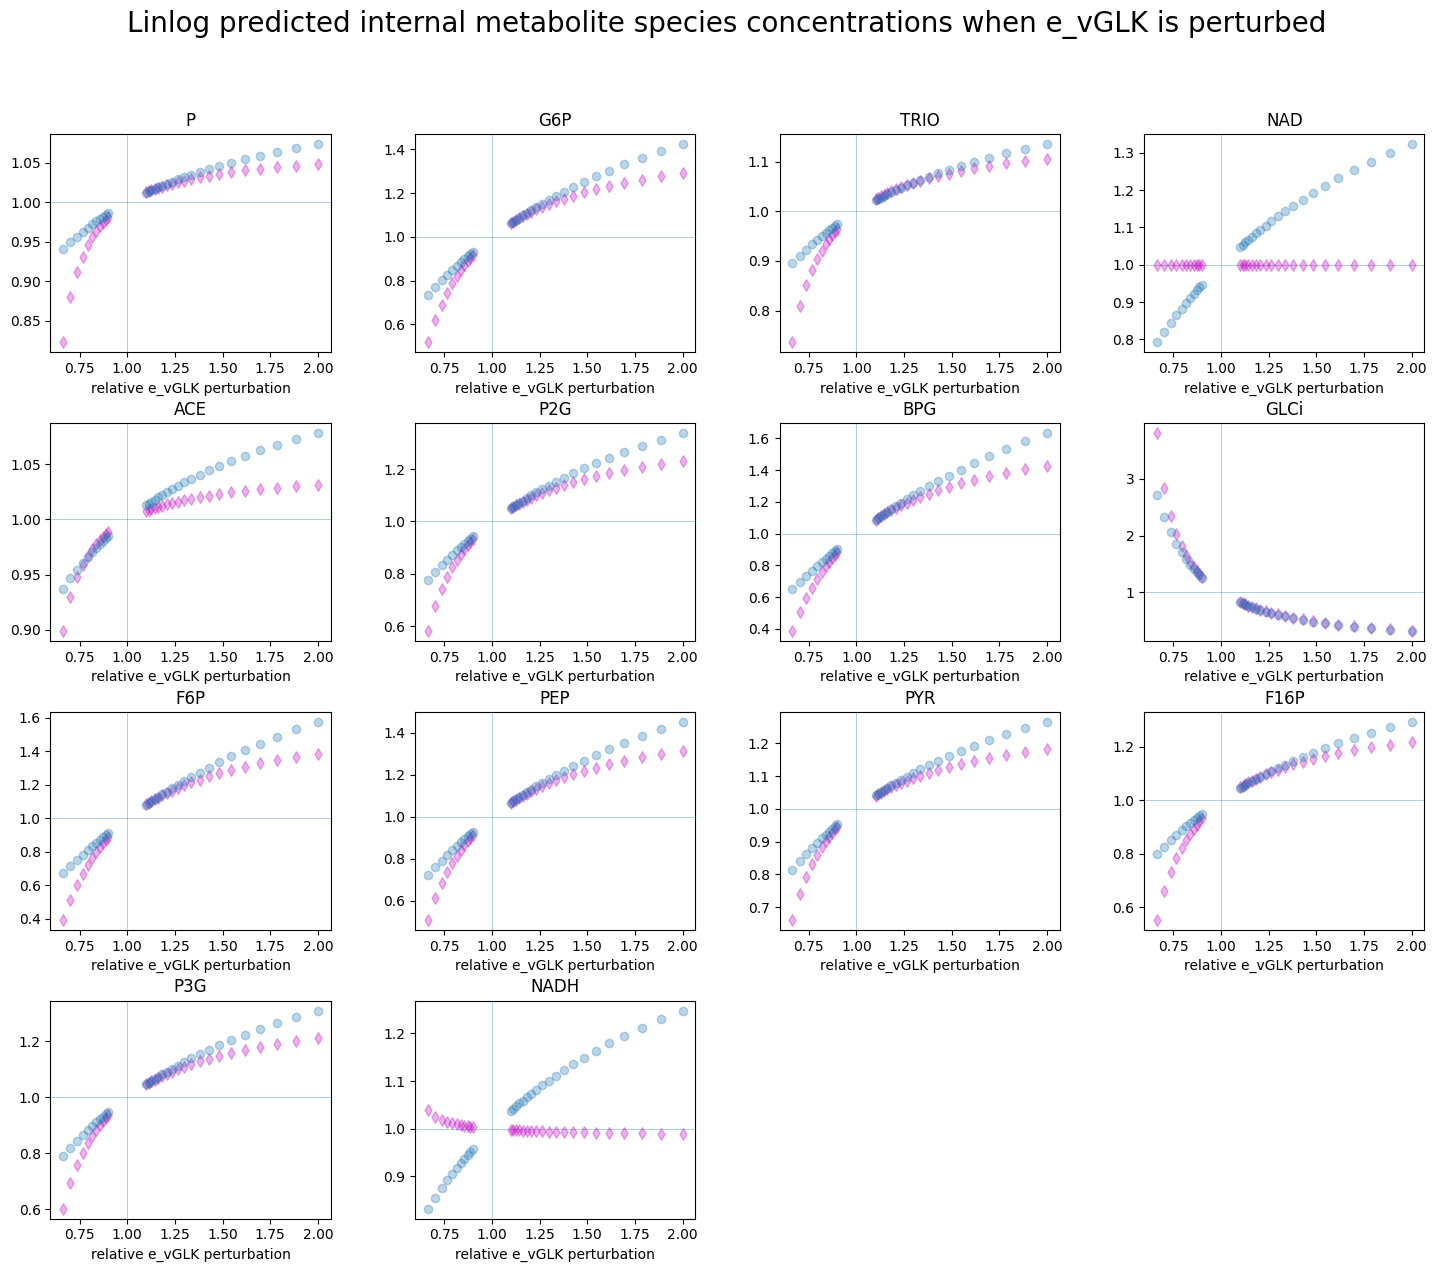

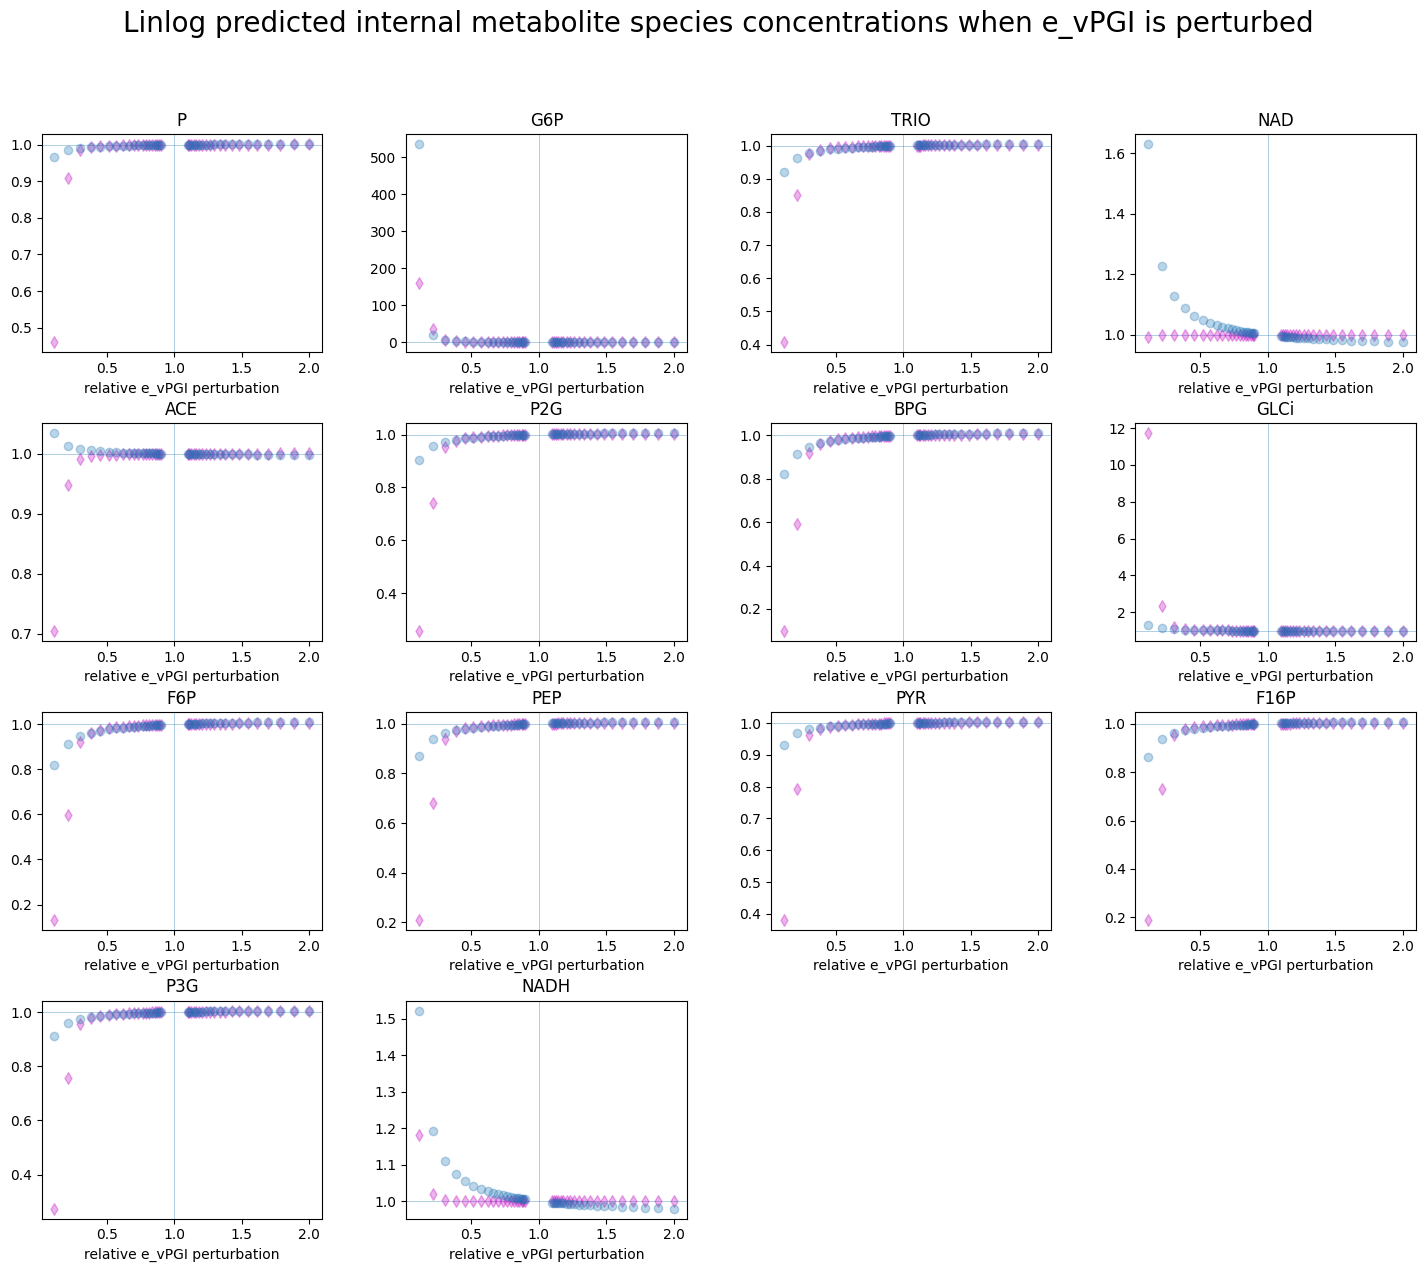

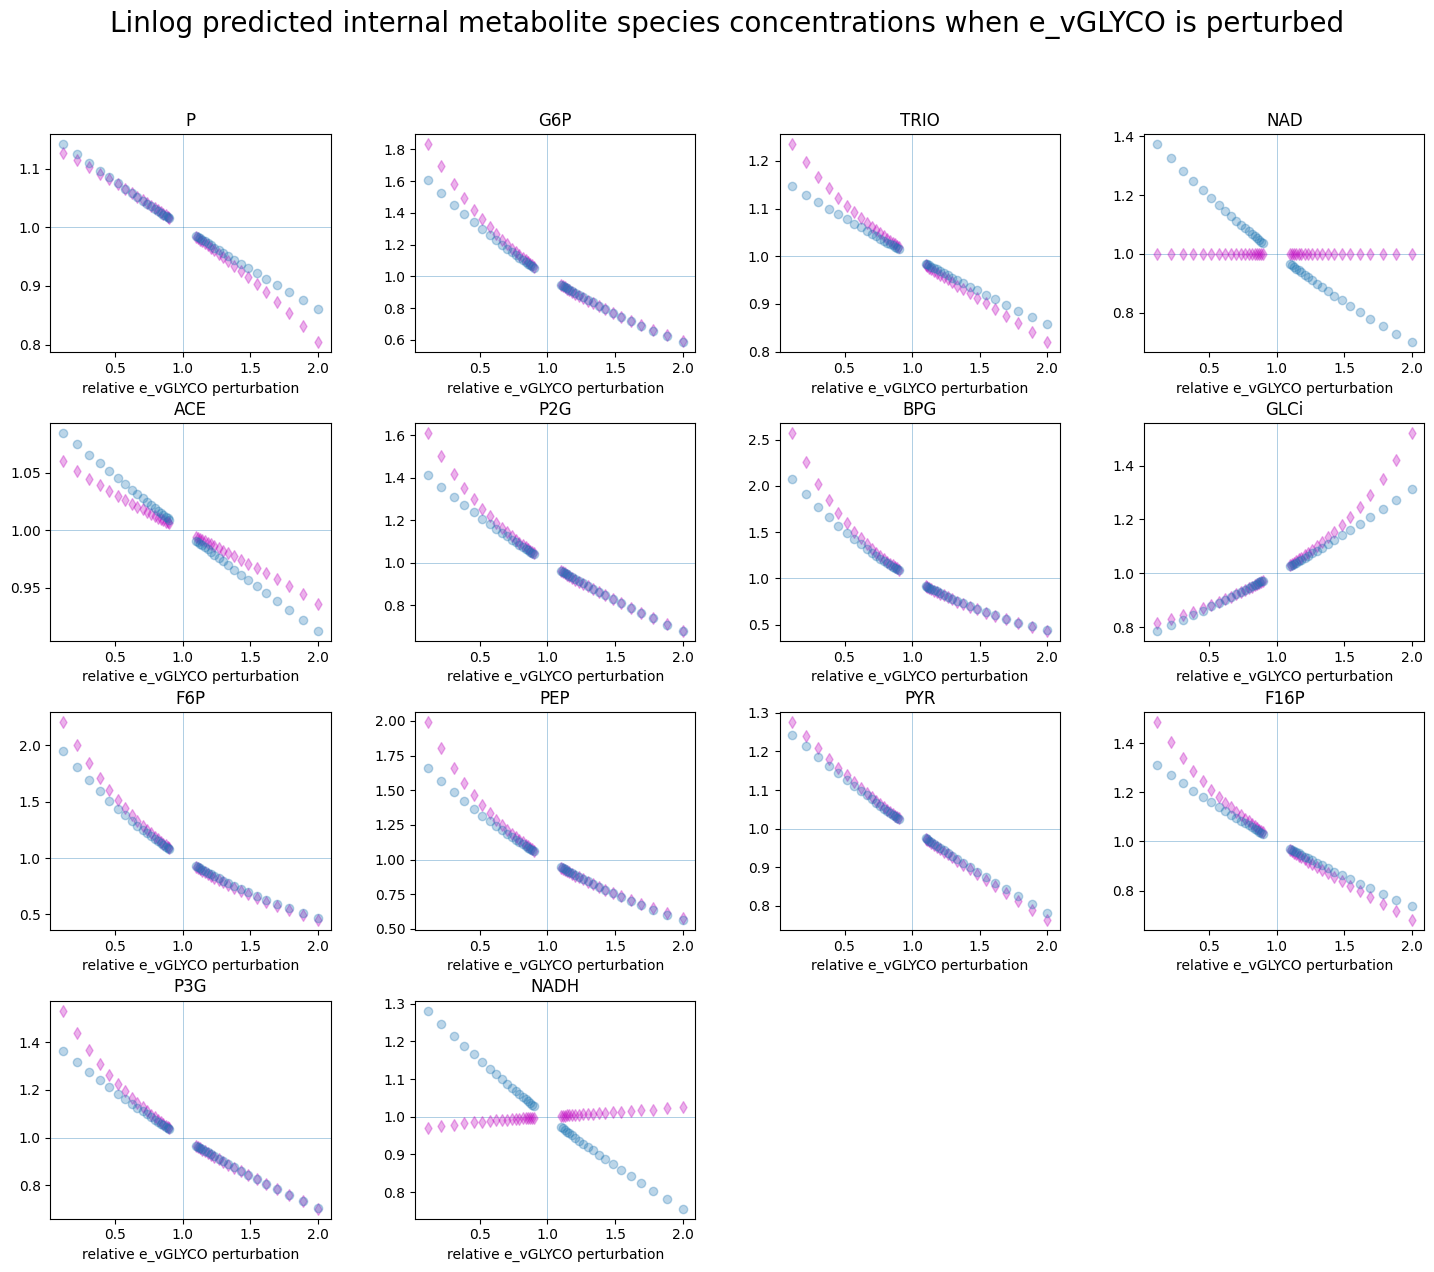

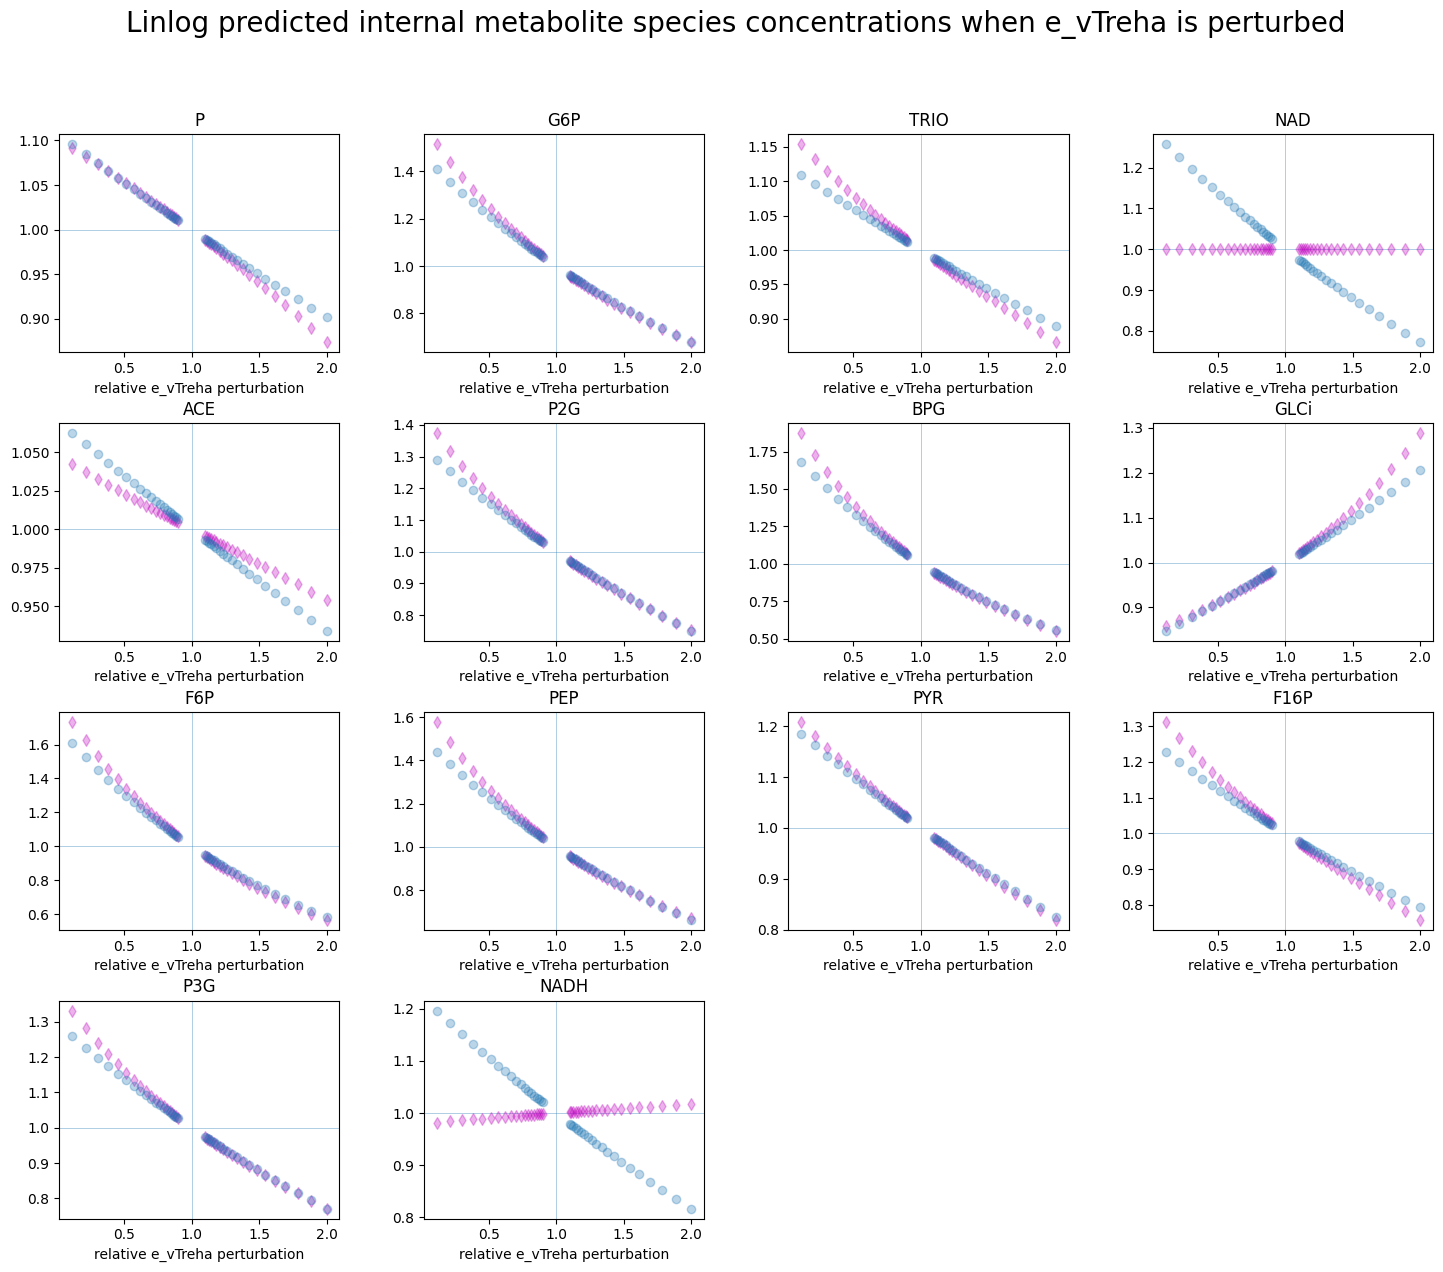

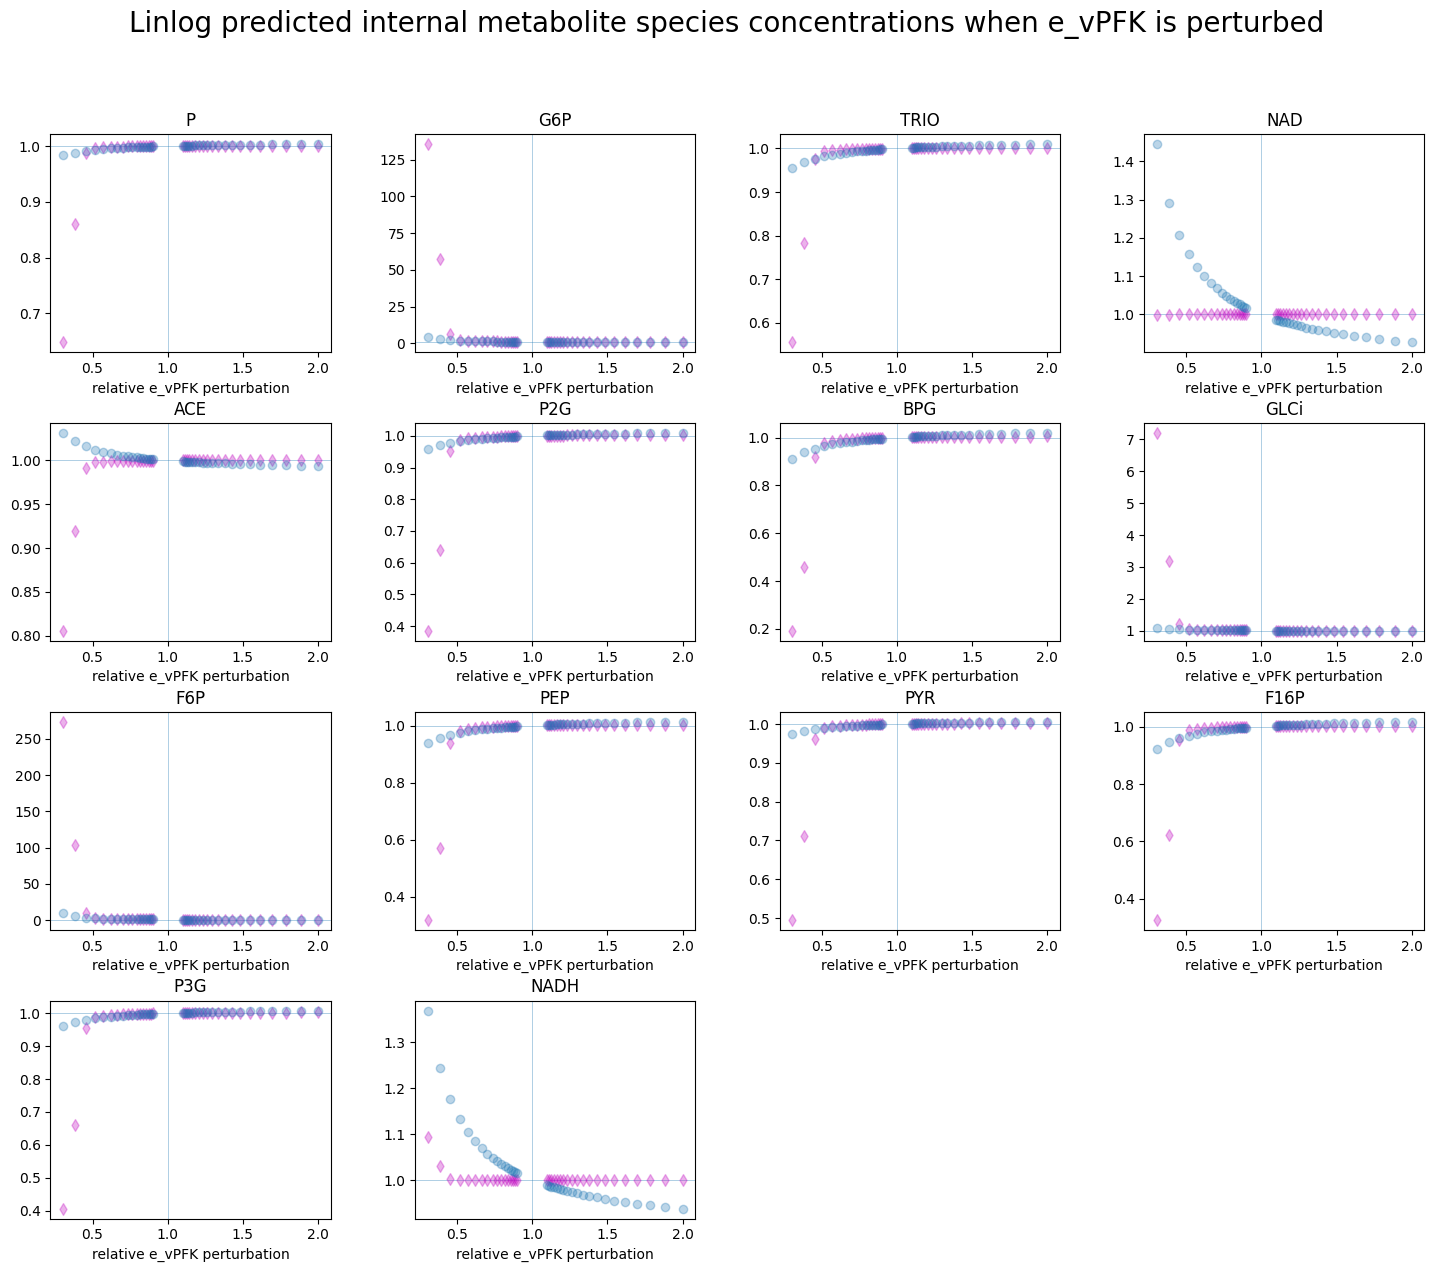

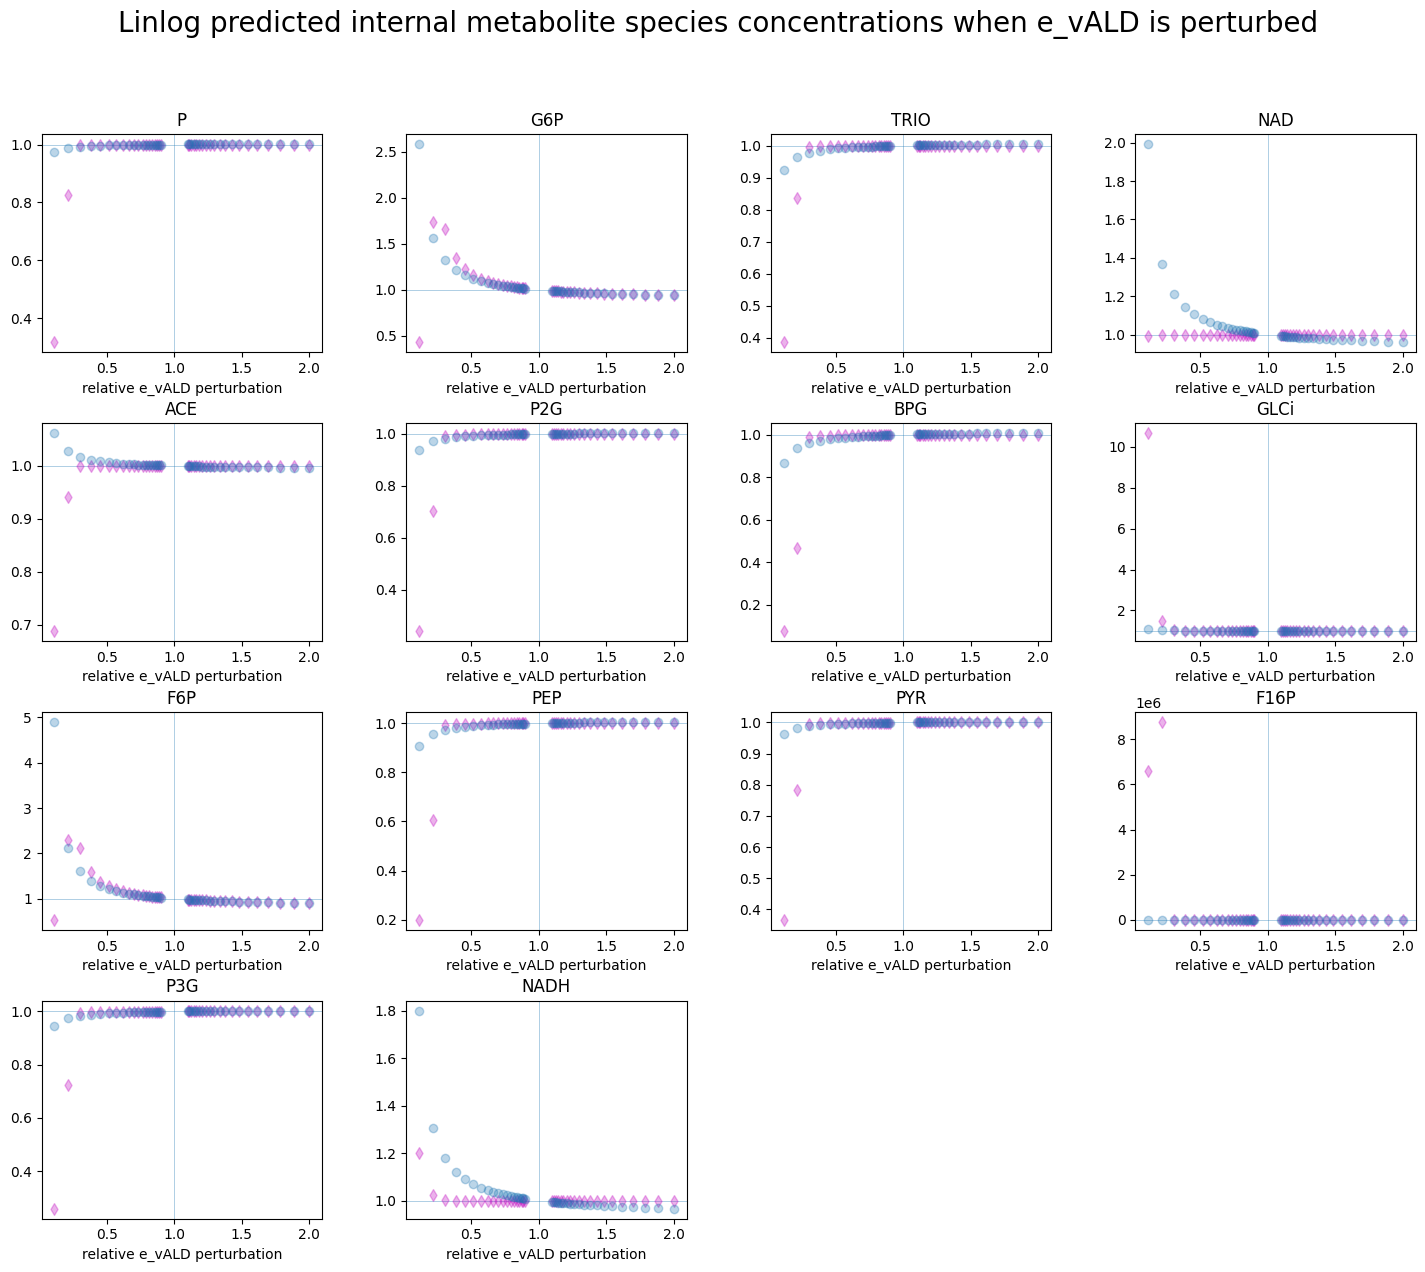

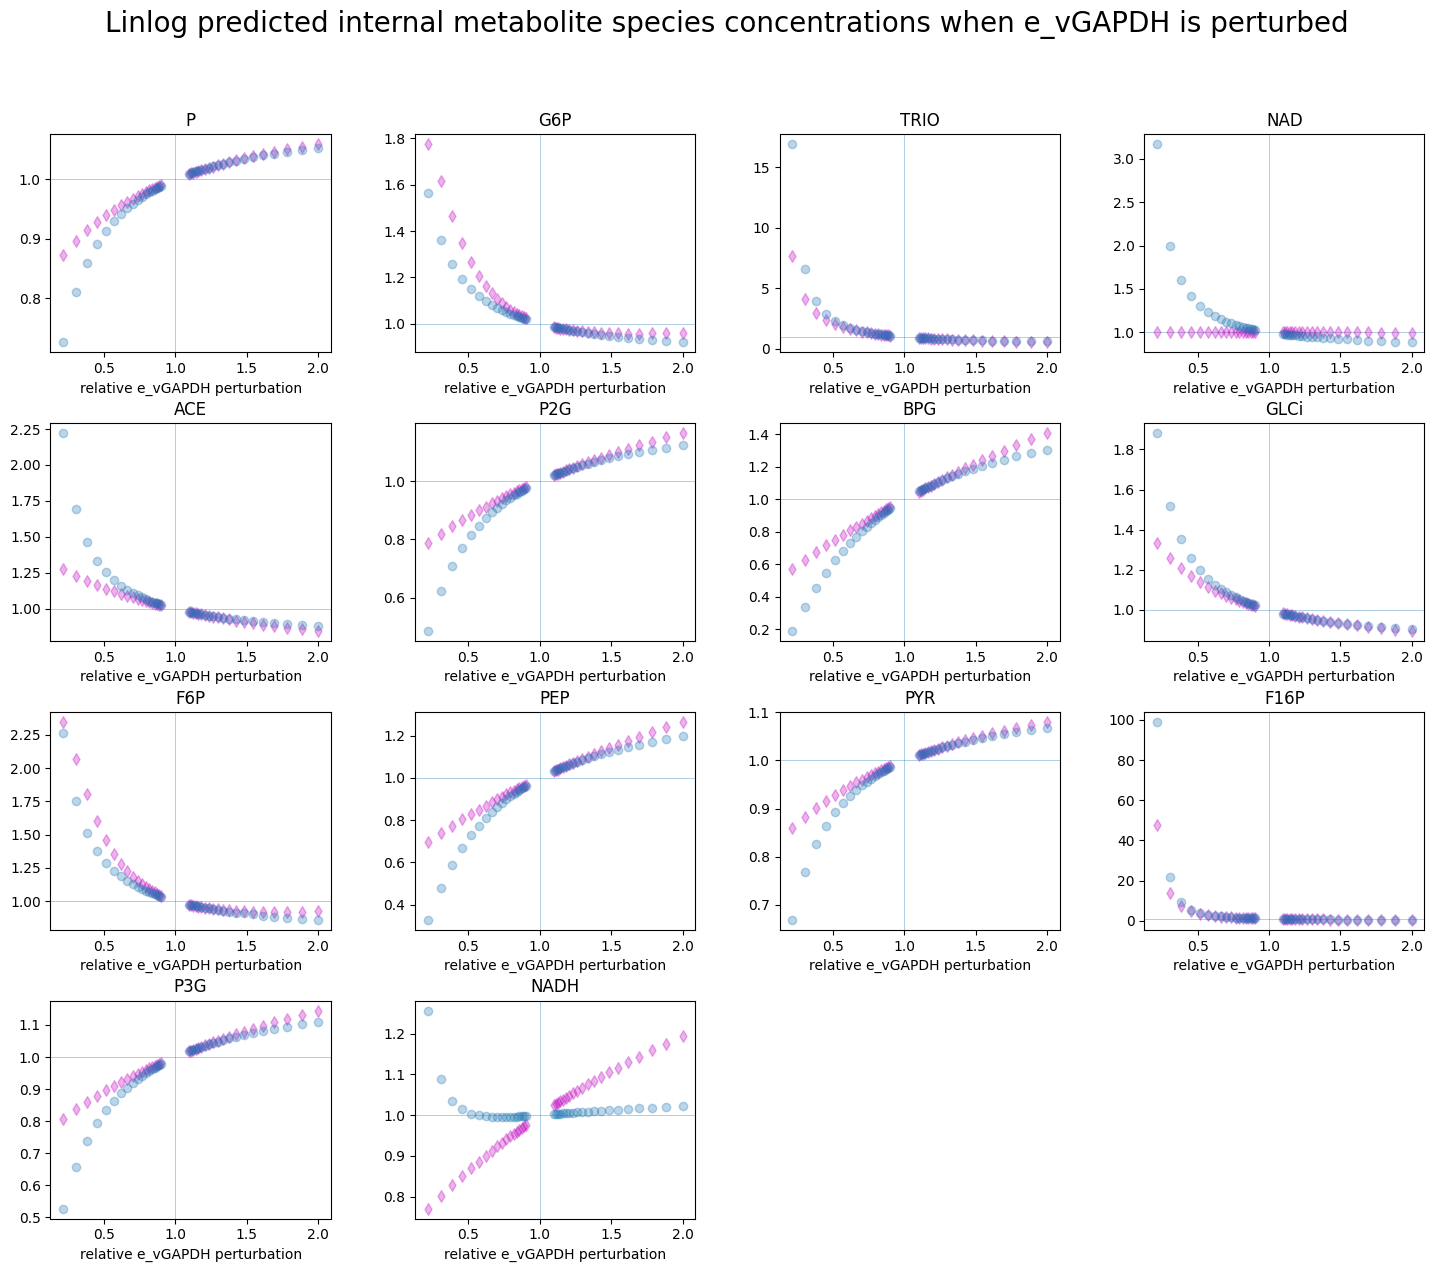

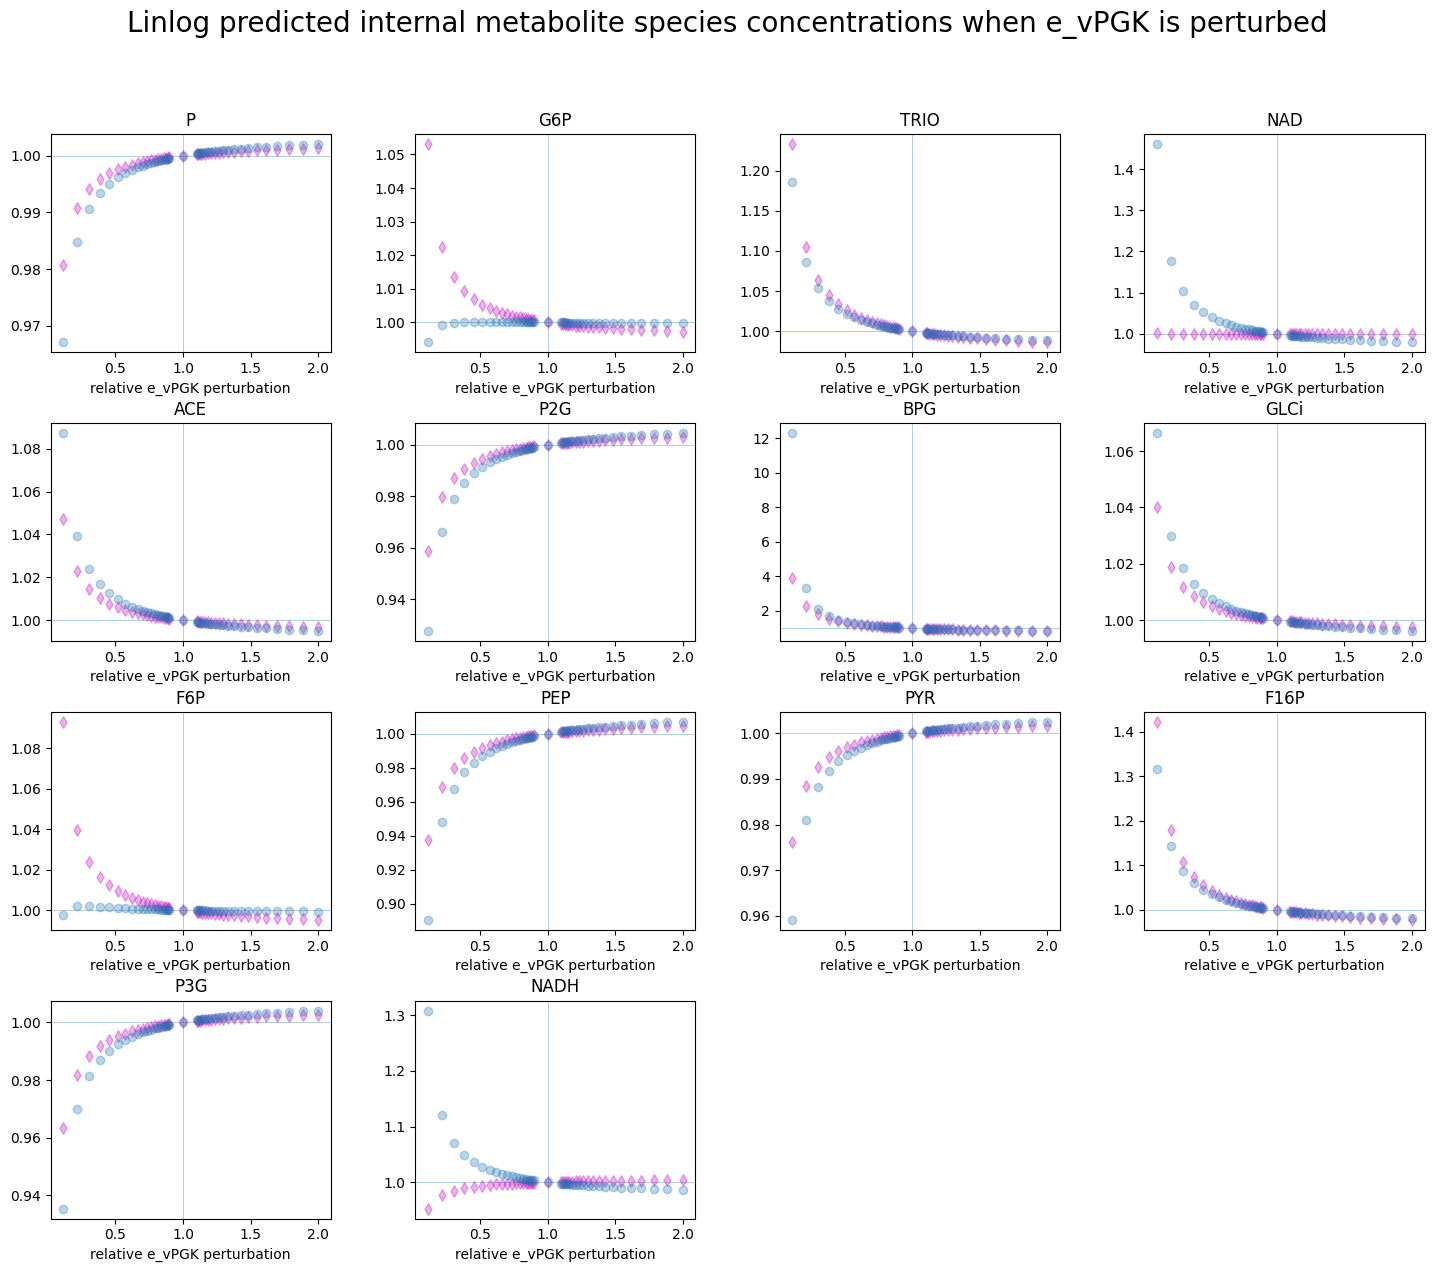

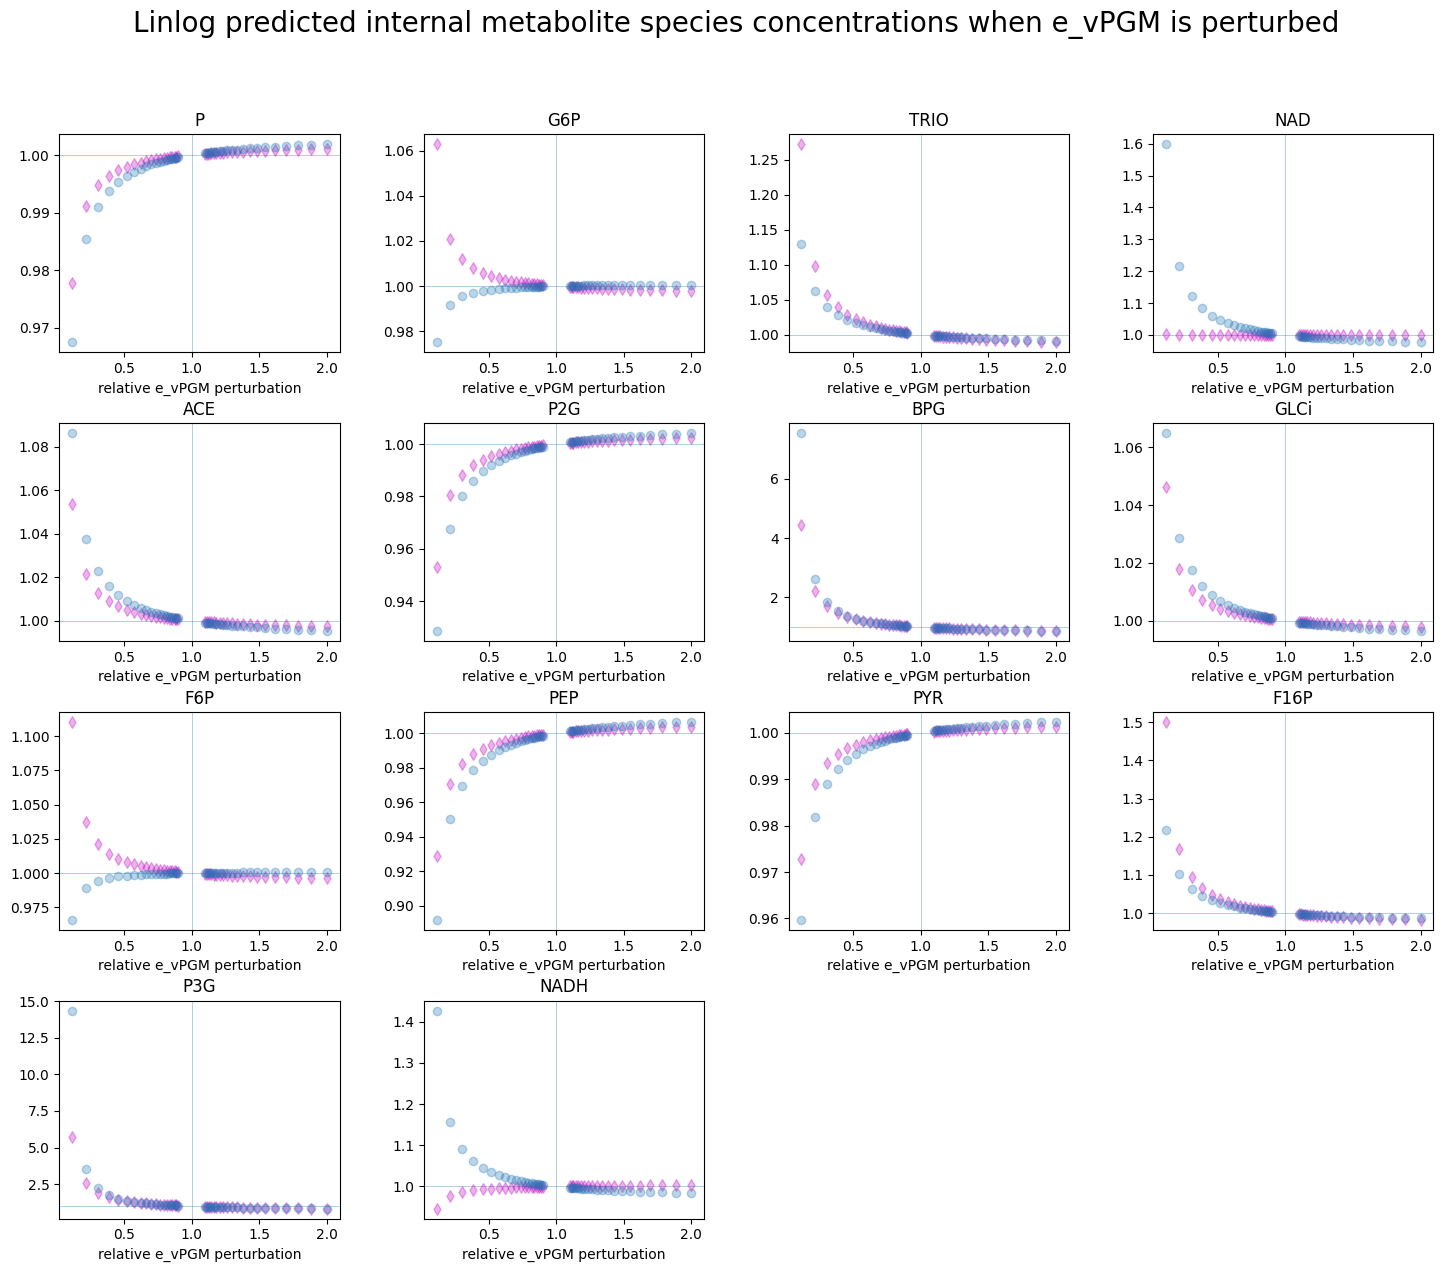

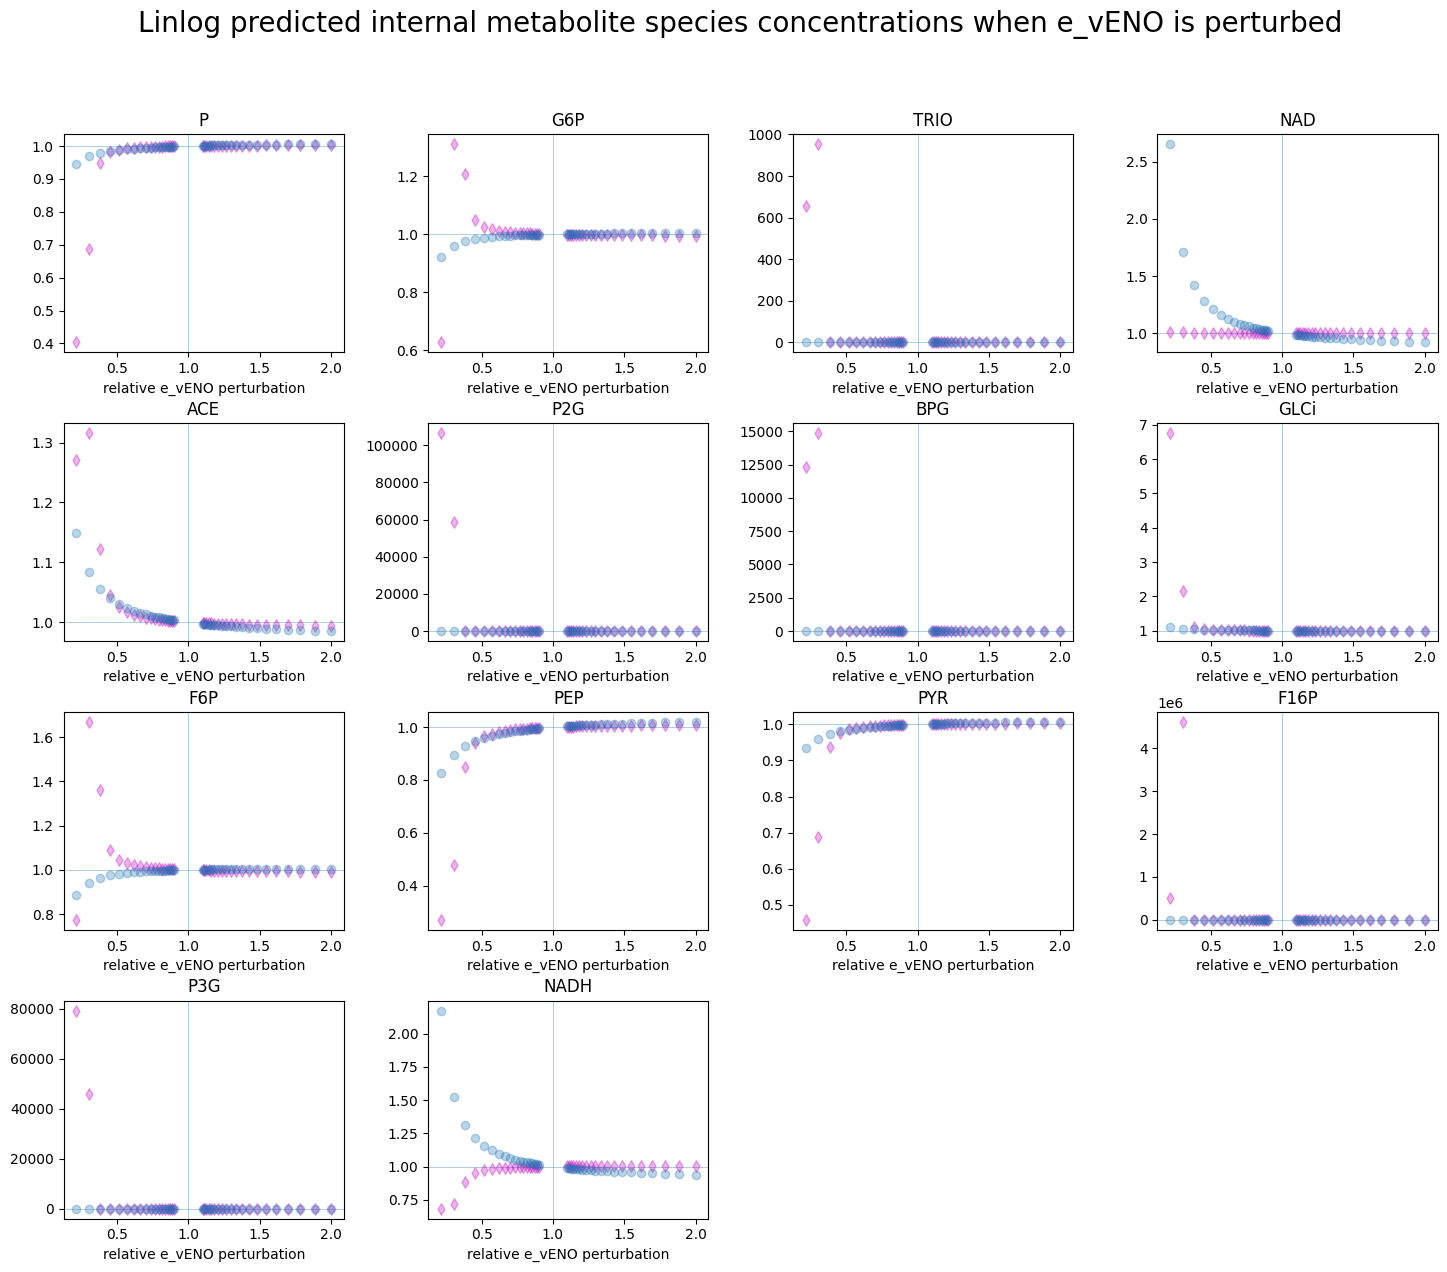

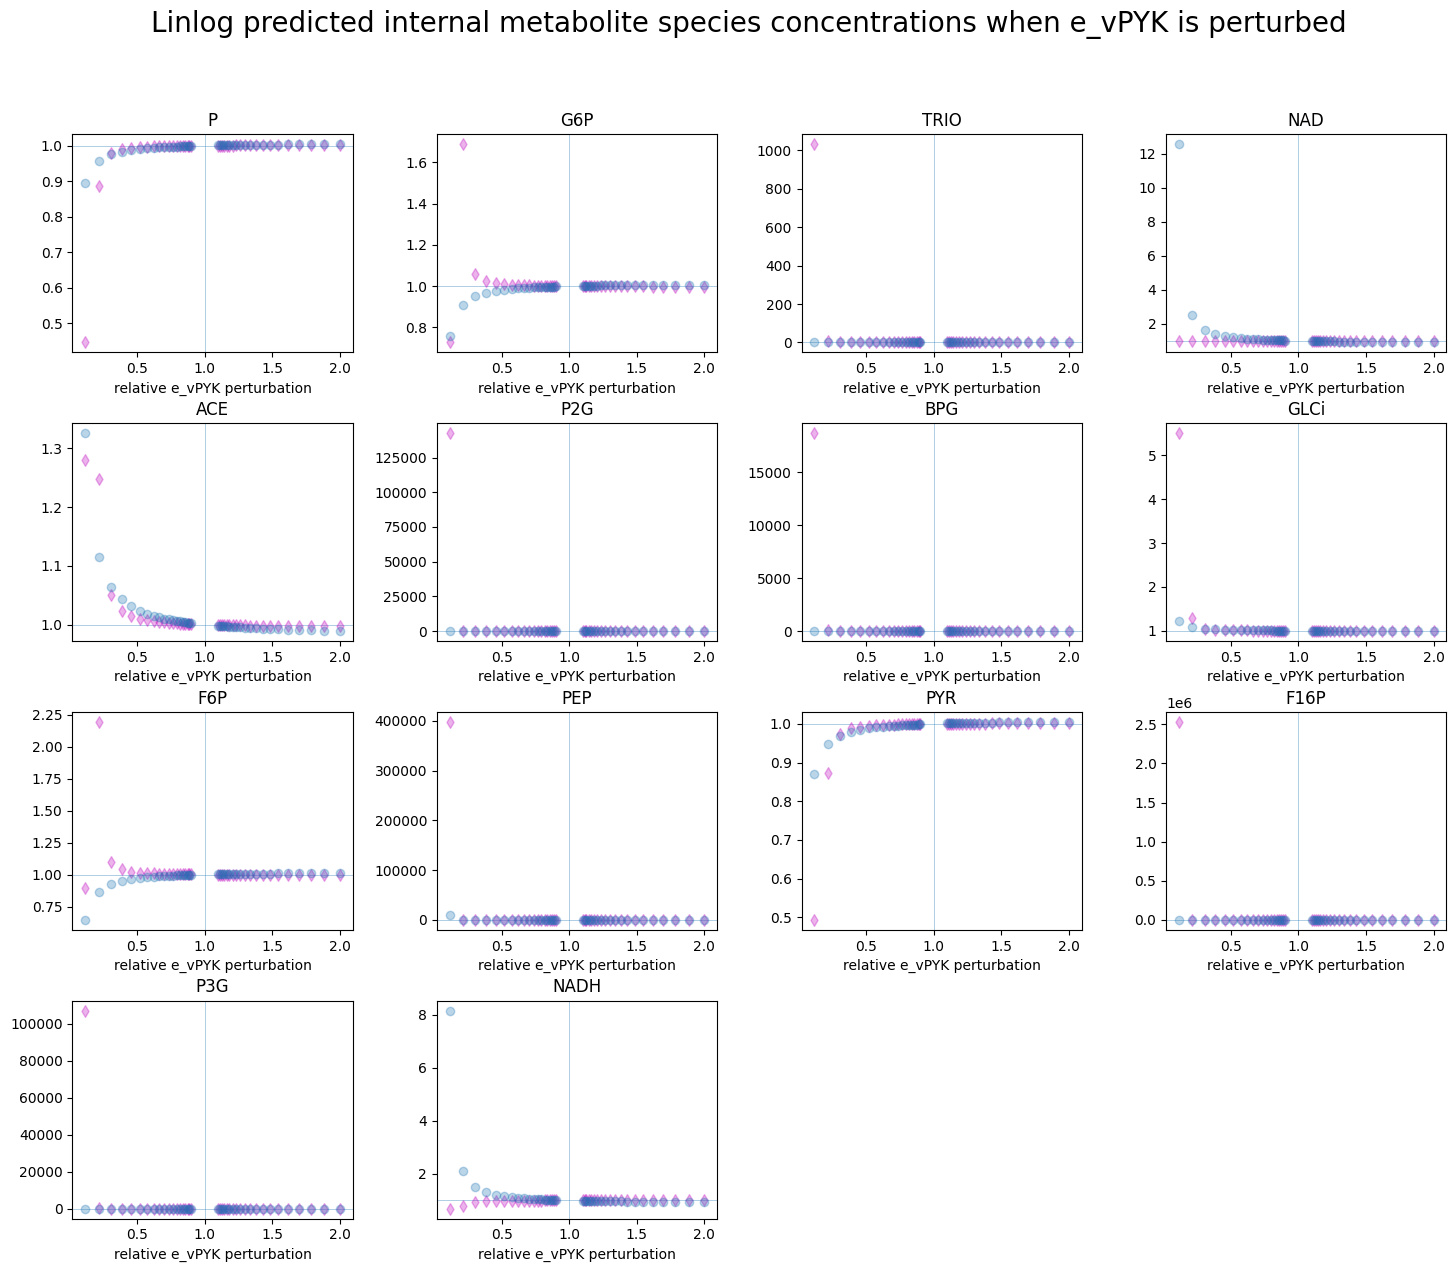

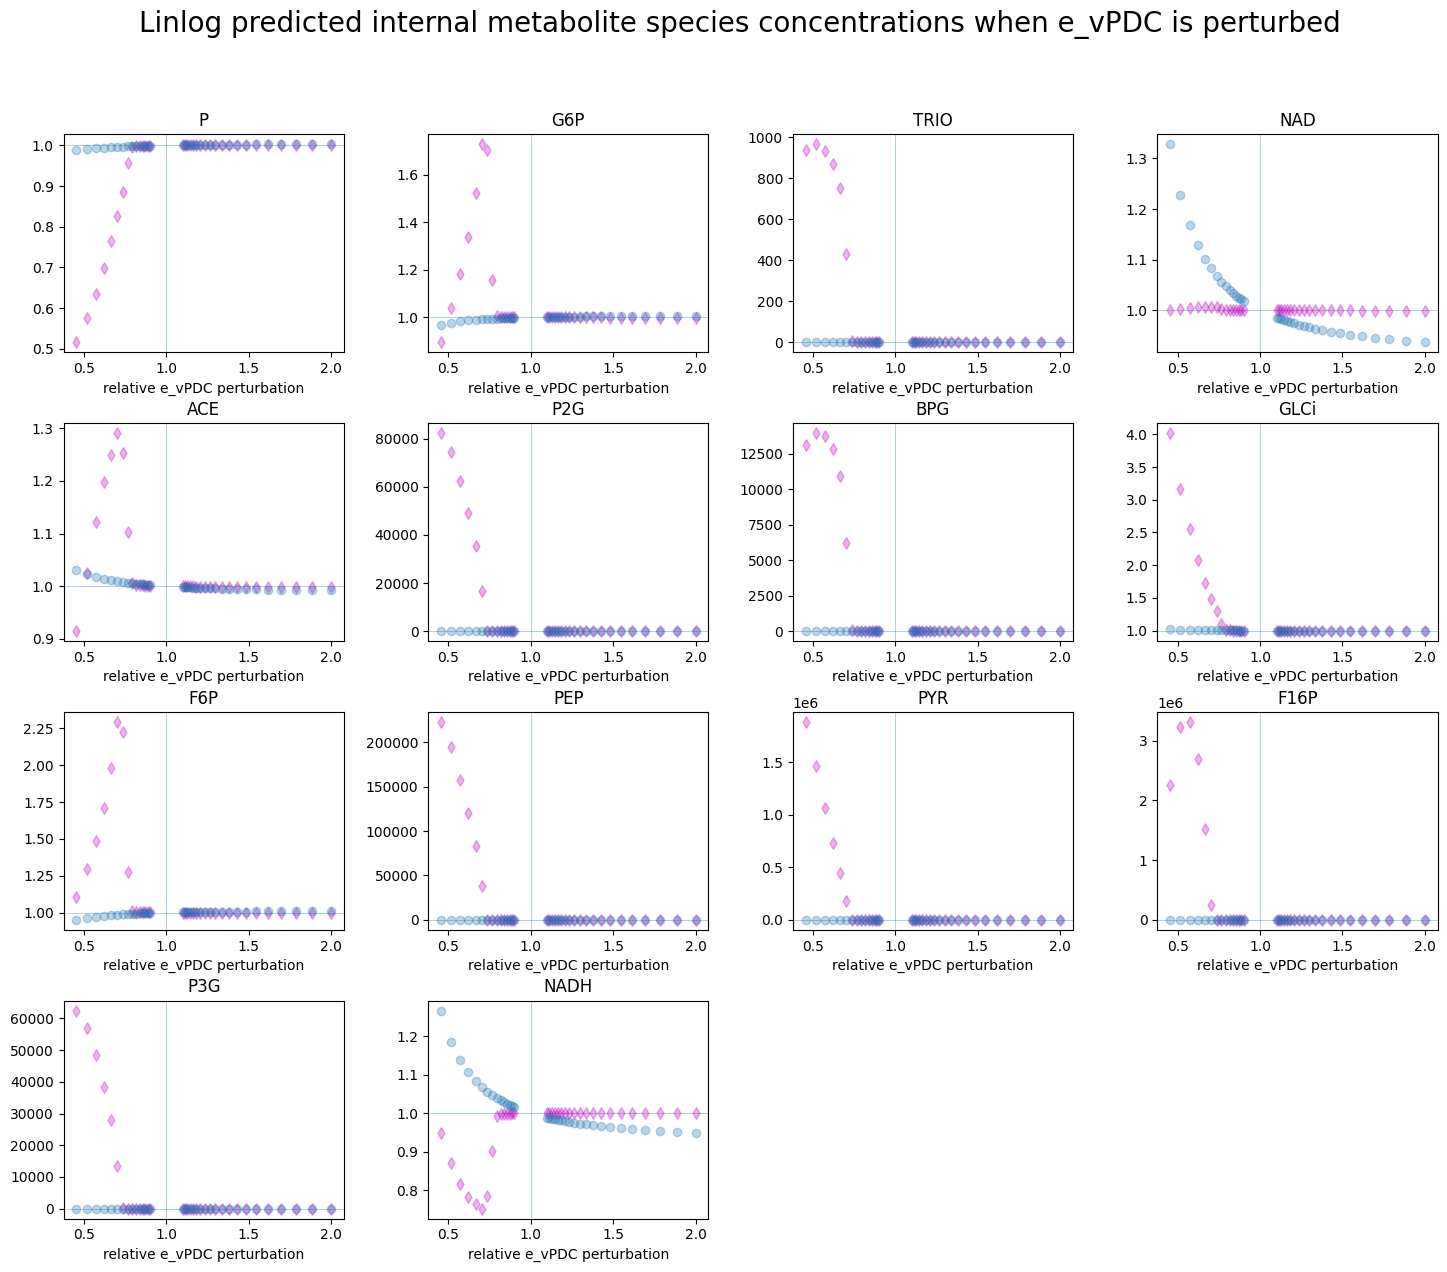

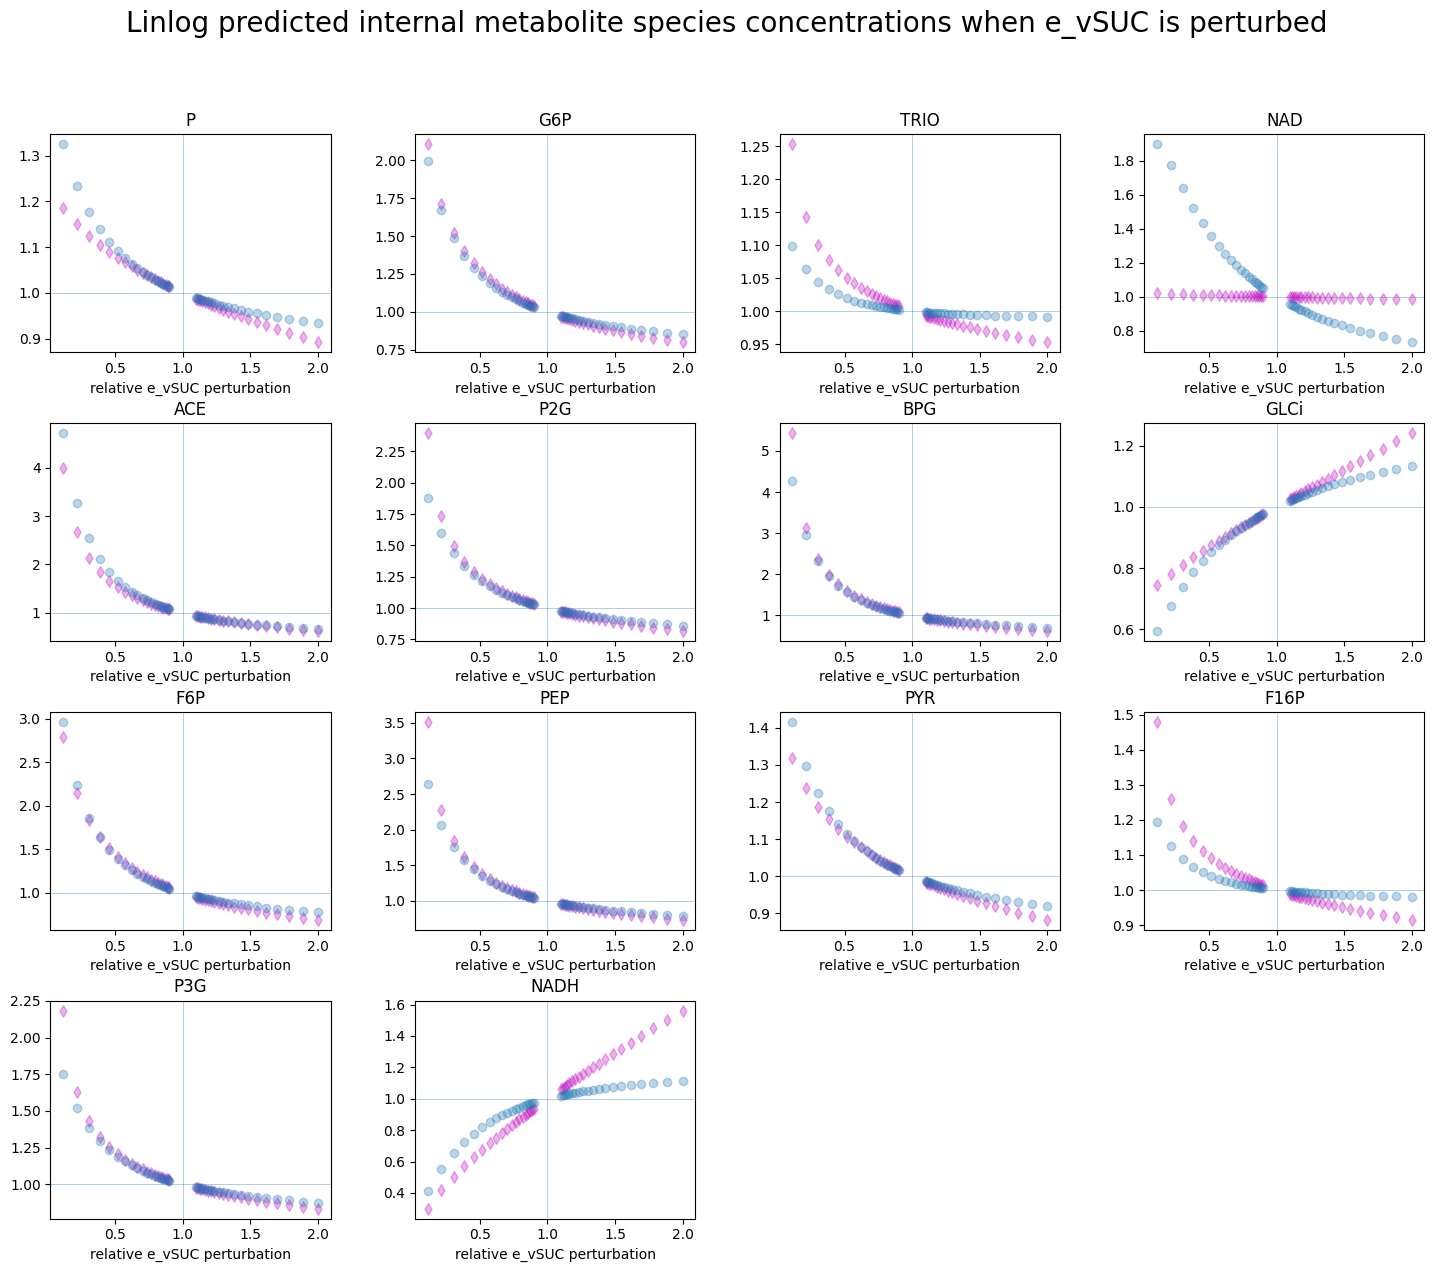

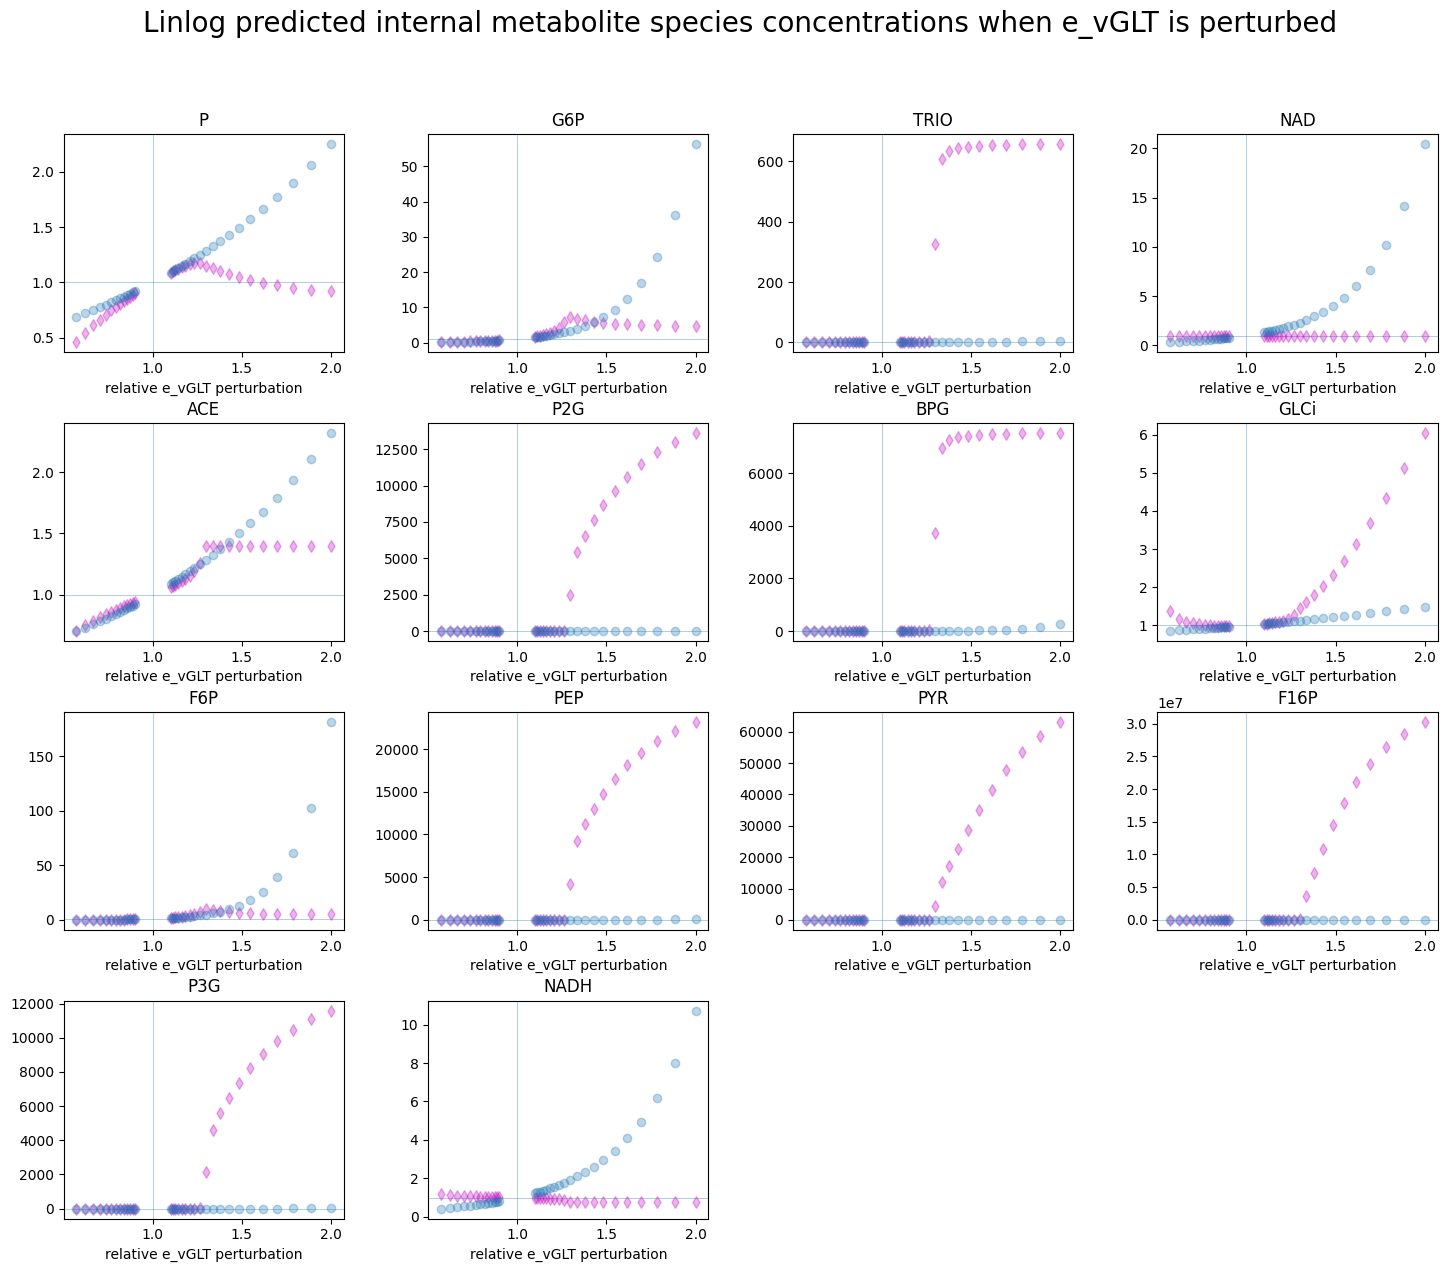

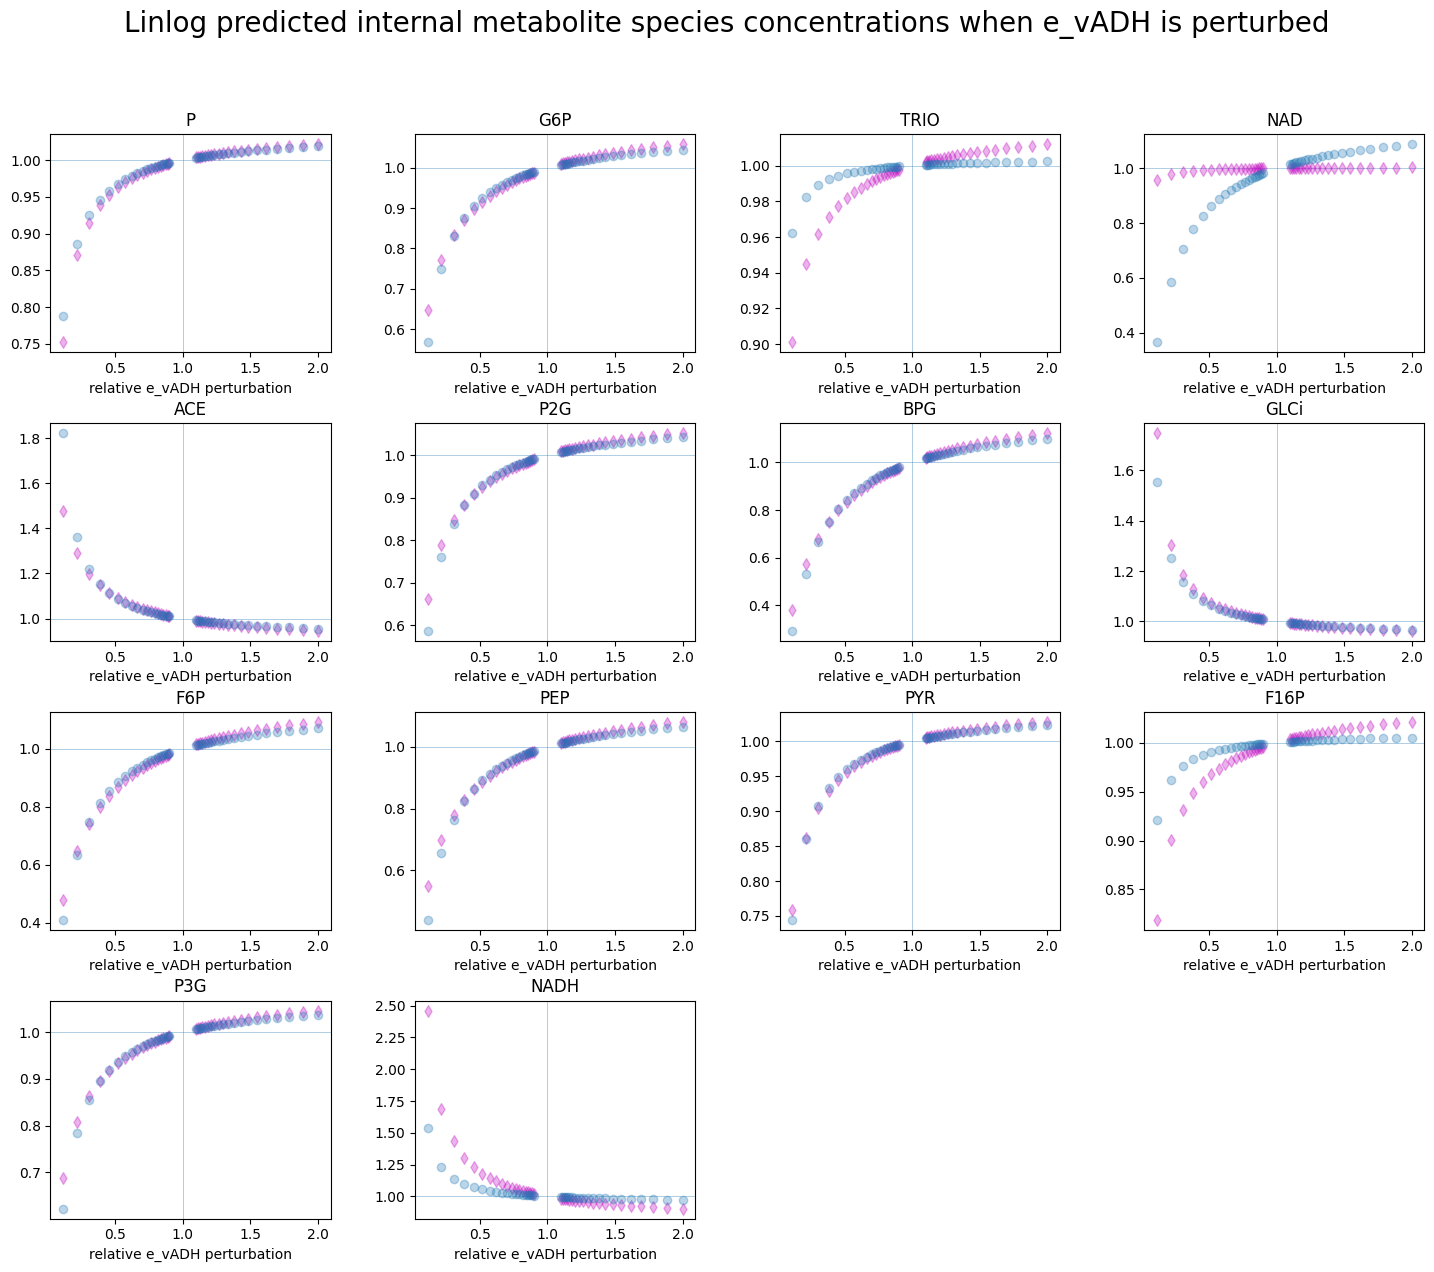

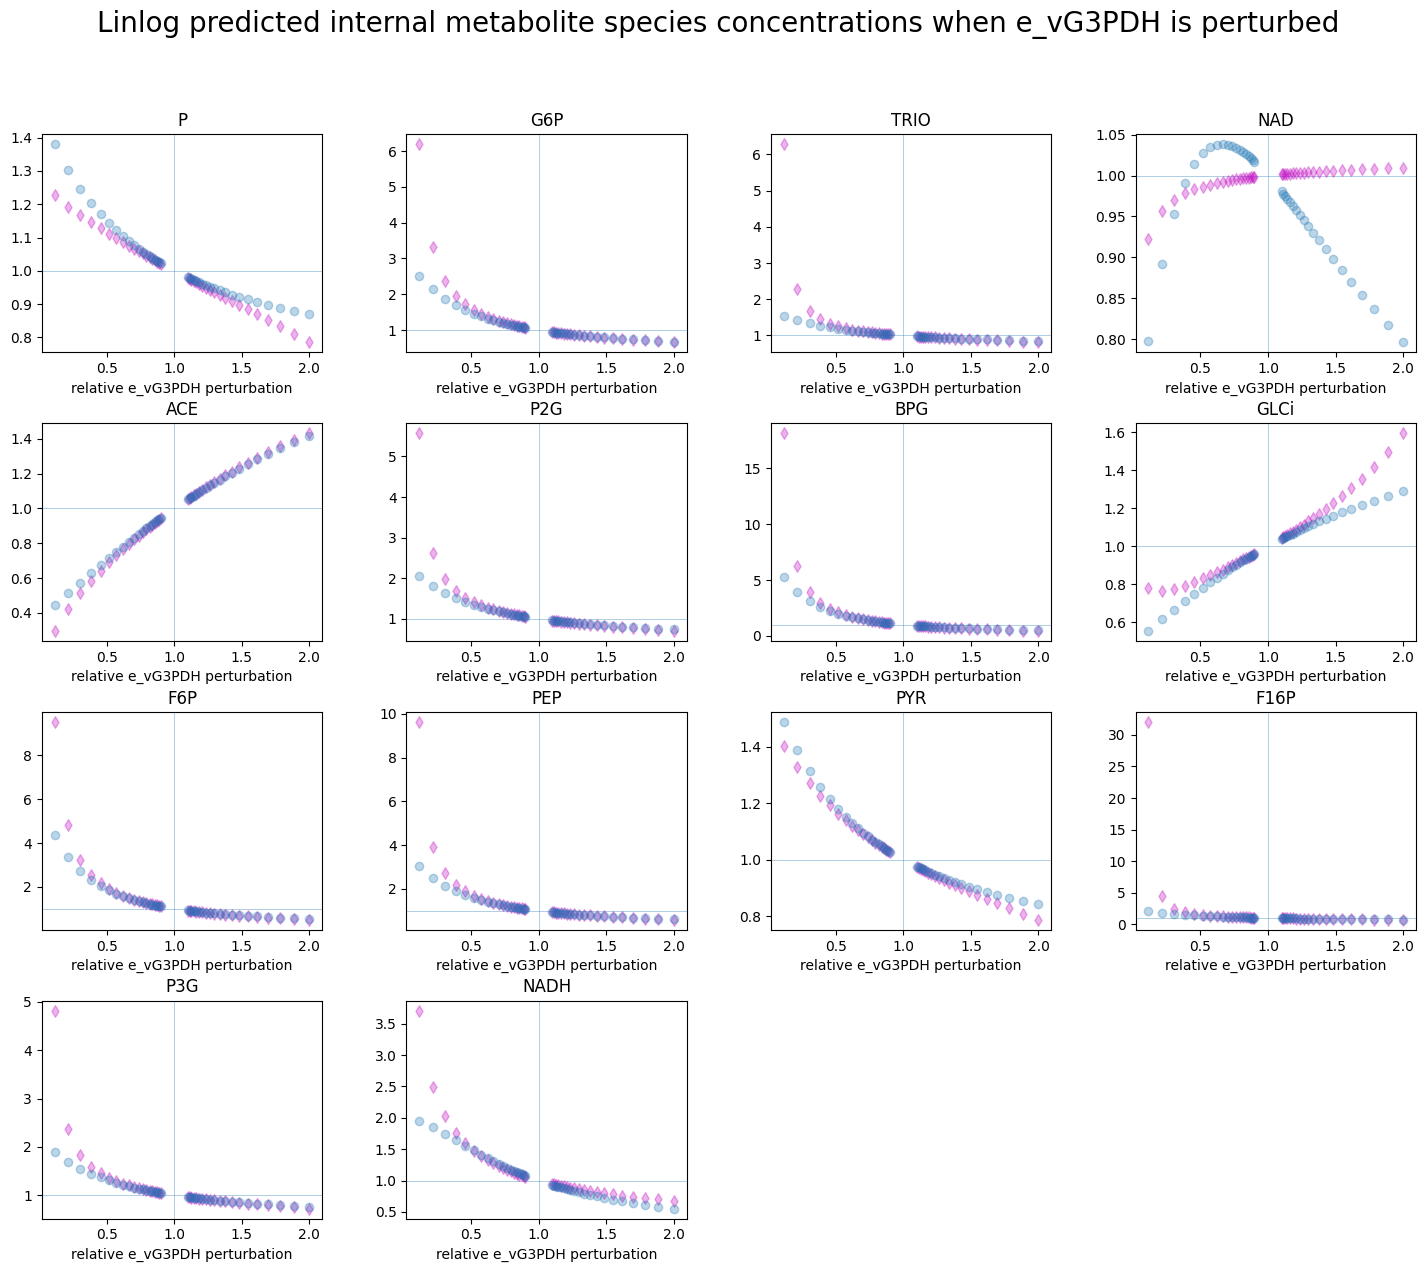

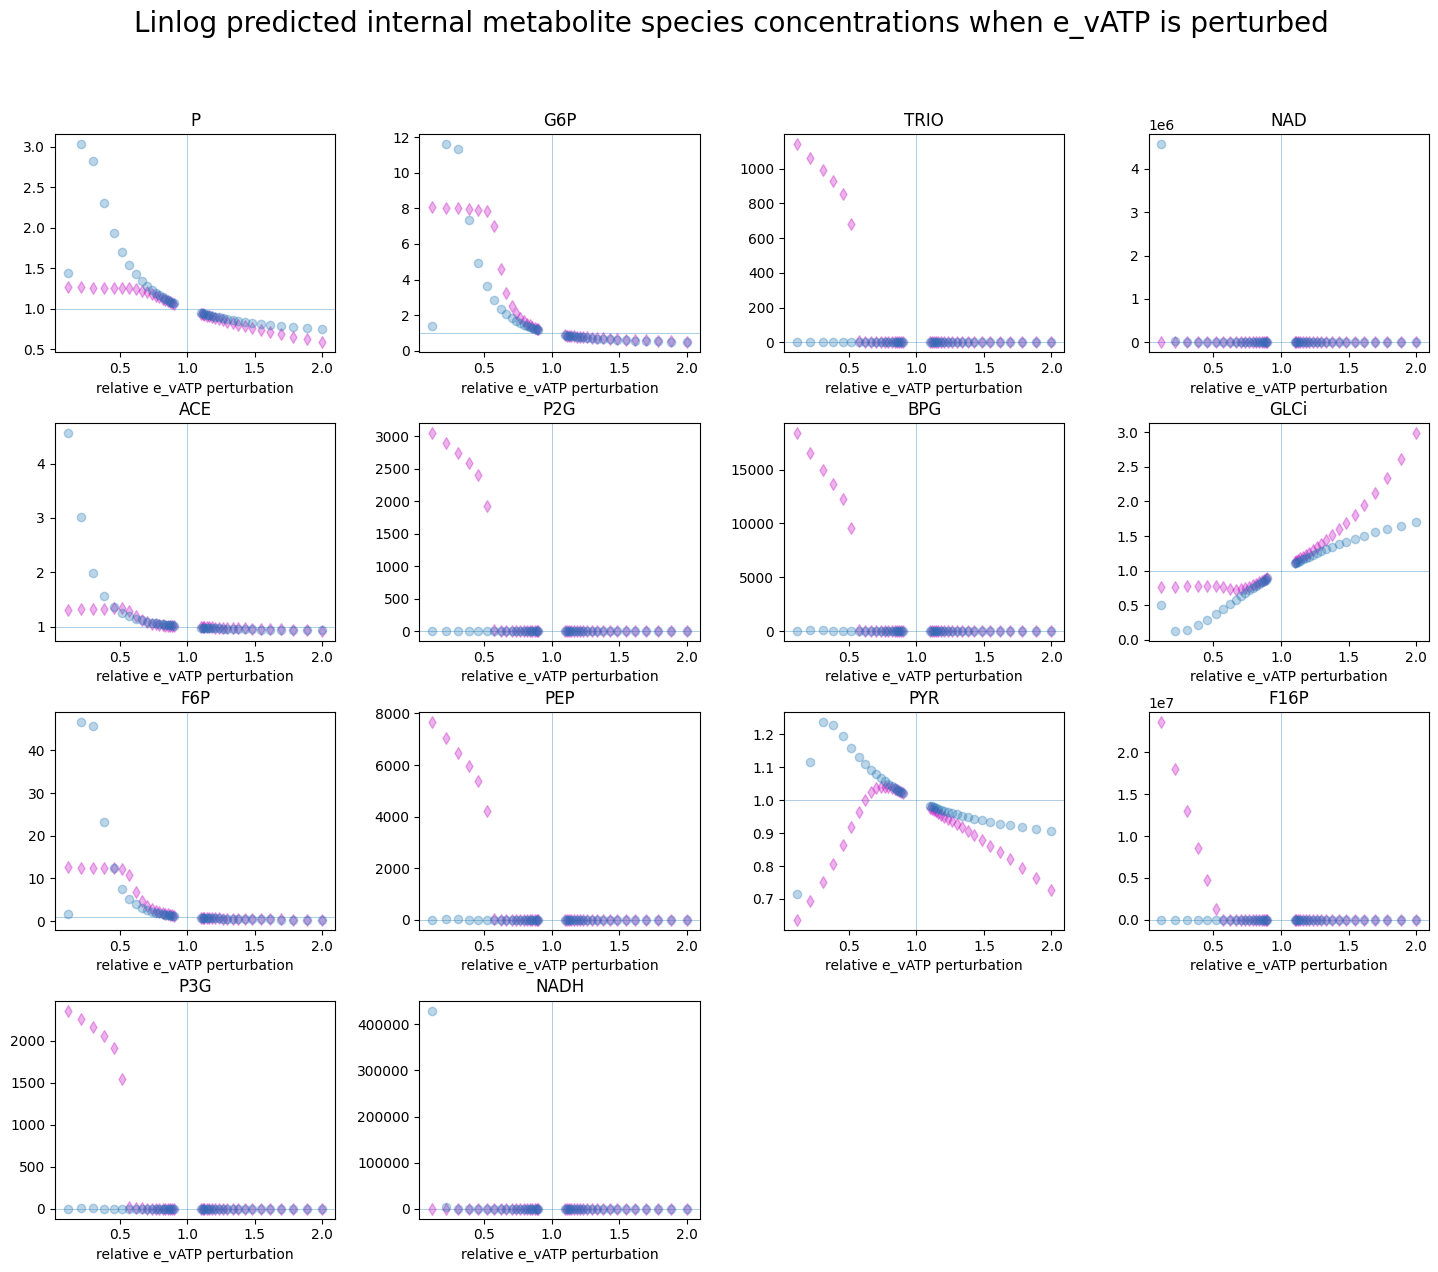

In [16]:
est_Xss = pd.DataFrame(np.exp(np.squeeze(np.array(Xss)).T), index=r.getFloatingSpeciesIds(), columns=enzPtLvls)
for rxn in r.getReactionIds(): 
    est_rxn_Xss = est_Xss[[i for i in est_Xss.columns if rxn in i]]
    est_rxn_Xss.columns = [float(i.split('|')[1]) for i in est_rxn_Xss.columns]
    est_rxn_Xss = est_rxn_Xss.reindex(sorted(est_rxn_Xss.columns), axis=1)
   
    rxn_inmet_perts = rel_real_inmet_values[[i for i in rel_real_inmet_values.columns if rxn in i]] 
    rxn_inmet_perts.columns=[i[7:] for i in rxn_inmet_perts.columns]
    rxn_inmet_perts = rxn_inmet_perts.reindex(sorted(rxn_inmet_perts.columns), axis=1)
    
    fig, axs = plt.subplots(4,4, figsize=(15, 13)) 
    idx_starter = -1

    fig.suptitle(f'Linlog predicted internal metabolite species concentrations when e_{rxn} is perturbed\n', fontsize = 20)
    fig.tight_layout(pad=3.0)

    for i,met in enumerate(r.getFloatingSpeciesIds()):
        if i%4==0:
            idx_starter += 1

        axs[idx_starter, i%4].scatter(est_rxn_Xss.columns, rxn_inmet_perts.loc[met].values, alpha=0.3, c='m', marker='d')
        axs[idx_starter, i%4].scatter(est_rxn_Xss.columns, est_rxn_Xss.loc[met], alpha=0.3)
        axs[idx_starter, i%4].set_xlabel(f'relative e_{rxn} perturbation')
        axs[idx_starter, i%4].axhline(1, linewidth=0.5, zorder=0, alpha=0.5)
        axs[idx_starter, i%4].axvline(x=1, linewidth=0.5, zorder=0, alpha=0.5)
        axs[idx_starter, i%4].set_title(met)
    
    fig.delaxes(axs[3,2]) 
    fig.delaxes(axs[3,3]) 


### Running Bayesian inference for internal steady state concentrations

In [ ]:
from emll.aesara_utils import LeastSquaresSolve
def mymethod(e_hat, v_star):
    n_exp = len(e_hat)
    
    v_star = v_star[np.newaxis,:]
    product = (e_hat*v_star)

    def my_func(a): 
        return np.diag(a)
    c = np.apply_along_axis(my_func, 1, product)
    
    N_rep = N.reshape((-1, *N.shape)).repeat(642, axis=0) # (642, 14, 17)
    
    As = (N_rep@c@Ex) # (642, 14, 14)
    
    arr = ((np.ones((len(N.T),n_exp)) + (Ey @ np.log(yn.T)))).values
    arr = arr.T[:,:, np.newaxis]
    bs = -(N_rep@c) @ arr # (642, 14, 642)

    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()
    
    xn, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)
    
    vn = e_hat * (np.ones((17, 642)) +
                   at.dot(Ex, xn.T) +
                   at.dot(Ey, yn.T)).T

    return xn, vn

In [26]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [27]:
with pymc_model:
    
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=e_hat)
    y_obs = pm.Normal('y_obs', mu=1, sigma=10, observed=yn)


In [194]:
with pymc_model:
    
    # likelihood = pm.Deterministic('vn', e_obs * (np.ones((17,641)) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    xn_ss, vn_ss = mymethod(e_hat, BIOMD64.v_star)
    chi_obs = pm.Normal('chi_obs', mu=xn_ss, sigma=1, observed=xn)
    v_hat_obs = pm.Normal('v_hat_obs', mu=vn_ss, sigma=1, observed=vn)

pymc_model.free_RVs

In [204]:
N_ITERATIONS = 50000
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n=       N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)

(5, 642)

In [ ]:
import seaborn as sns
with sns.plotting_context('notebook', font_scale=1.2):

    fig = plt.figure(figsize=(5,4))
    plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
    # plt.ylim([-1E1, 1E3])
    plt.xlim([0, 50000])
    sns.despine(trim=True, offset=10)

    plt.ylabel('-ELBO')
    plt.xlabel('Iteration')
    plt.title('in vitro ADVI convergence')
    plt.tight_layout()
    # plt.savefig('wu_elbo.svg', transparent=True, dpi=200)

## Solving for steady state external metabolite concentrations (Y)

In [17]:
A = (N_rep@c@Ey) # (642, 14, 14)
arr = ((np.ones((len(N.T),n_exp)) + (Ex @ np.log(xn.T)))).values
arr = arr.T[:,:, np.newaxis]
b = -(N_rep@c) @ arr # (642, 14, 642)

Yss = []
for i in range(n_exp): 
    Yss.append(np.linalg.pinv(A[i])@b[i])

ValueError: shapes (17, 14) and (5, 642) not aligned

In [16]:
est_Yss = pd.DataFrame(np.exp(np.squeeze(np.array(Yss)).T), index=r.getFloatingSpeciesIds(), columns=enzPtLvls)
for rxn in r.getReactionIds(): 
    est_rxn_Yss = est_Yss[[i for i in est_Yss.columns if rxn in i]]
    est_rxn_Yss.columns = [float(i.split('|')[1]) for i in est_rxn_Yss.columns]
    est_rxn_Yss = est_rxn_Yss.reindex(sorted(est_rxn_Yss.columns), axis=1)
    
    rxn_exmet_perts = rel_real_exmet_values[[i for i in rel_real_exmet_values.columns if rxn in i]] 
    rxn_exmet_perts.columns=[i[7:] for i in rxn_exmet_perts.columns]
    rxn_exmet_perts = rxn_exmet_perts.reindex(sorted(rxn_exmet_perts.columns), axis=1)
    
    fig, axs = plt.subplots(2,3, figsize=(15, 13)) 
    idx_starter = -1

    fig.suptitle(f'Linlog predicted external metabolite species concentrations when e_{rxn} is perturbed\n', fontsize = 20)
    fig.tight_layout(pad=3.0)

    for i,met in enumerate(r.getBoundarySpeciesIds()):
        if i%3==0:
            idx_starter += 1

        axs[idx_starter, i%3].scatter(est_rxn_Yss.columns, rxn_exmet_perts.loc[met].values, alpha=0.3, c='m', marker='d')
        axs[idx_starter, i%3].scatter(est_rxn_Yss.columns, est_rxn_Yss.loc[met], alpha=0.3)
        axs[idx_starter, i%3].set_xlabel(f'relative e_{rxn} perturbation')
        axs[idx_starter, i%3].axhline(1, linewidth=0.5, zorder=0, alpha=0.5)
        axs[idx_starter, i%3].axvline(x=1, linewidth=0.5, zorder=0, alpha=0.5)
        axs[idx_starter, i%3].set_title(met)
    
    fig.delaxes(axs[1,2]) 


NameError: name 'Yss' is not defined

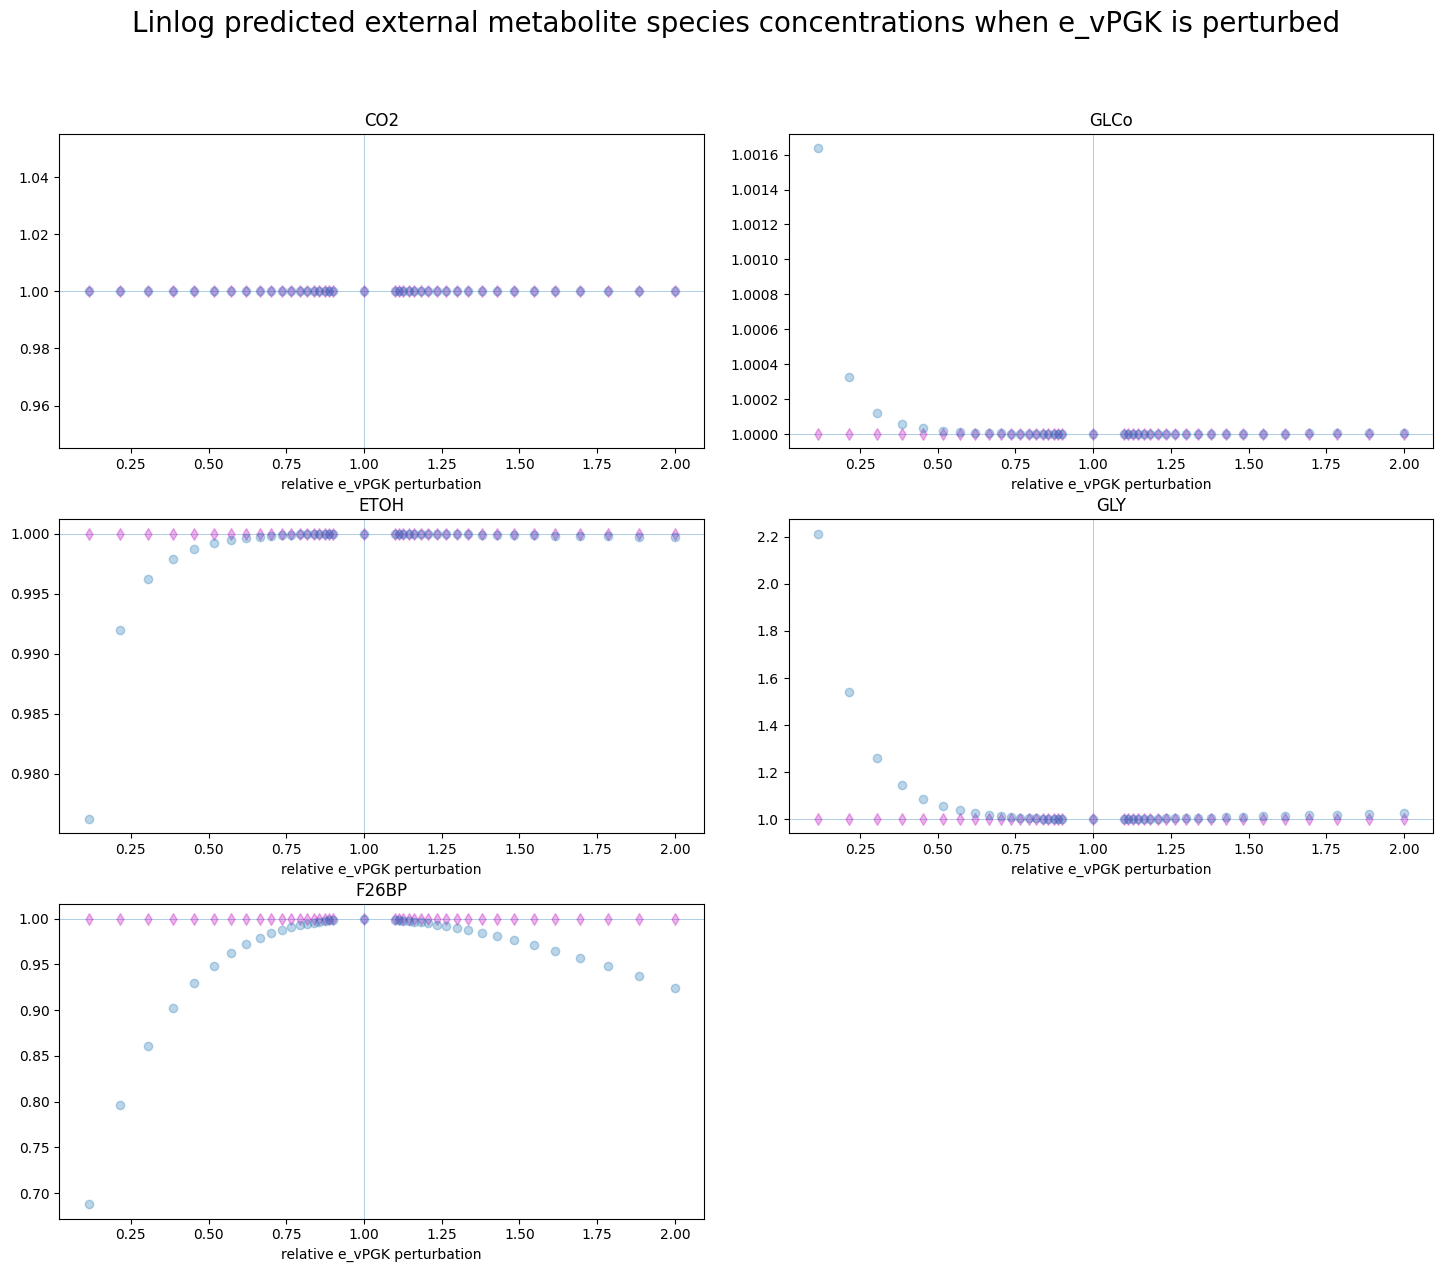

In [68]:
# establish the names of each boundary specie
Yss.index = r.getBoundarySpeciesIds()
# plot for each metabolite 
# create a subplot that is (3,2)
fig, axs = plt.subplots(3,2, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Linlog predicted external metabolite species concentrations when e_vPGK is perturbed\n', fontsize = 20)
fig.tight_layout(pad=3.0)

for i,met in enumerate(r.getBoundarySpeciesIds()):
    if i%2==0:
        idx_starter += 1

    axs[idx_starter, i%2].scatter(Yss.columns, PGK_exmet_perts.loc[met], alpha=0.3, c='m', marker='d')
    axs[idx_starter, i%2].scatter(Yss.columns, Yss.loc[met], alpha=0.3)
    axs[idx_starter, i%2].set_xlabel('relative e_vPGK perturbation')
    axs[idx_starter, i%2].set_title(met)
  
    axs[idx_starter, i%2].axhline(1, linewidth=0.5, zorder=0, alpha=0.5)
    axs[idx_starter, i%2].axvline(x=1, linewidth=0.5, zorder=0, alpha=0.5)

fig.delaxes(axs[2,1]) 
